In [1]:
import eigen_rootfinding as er
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from tests.devastating_example_test_scripts import *
from tests.conditioning_ratios import *
from scipy.stats import linregress
%load_ext autoreload
%autoreload 2

# Conditioning Ratios and Growth Rates

Recall that the absolute condition number of a simple root $\mathbf z$ of $f:\mathbb{R}^n\mapsto\mathbb{R}^n$ is:
    $$\kappa(\mathbf z,f) = \left\lVert{Df(\mathbf z)^{-1}}\right\rVert,$$
where $Df$ is the Jacobian of $f$
and that the condition number of a simple eigenvalue $\lambda$ of matrix A with left and right eigenvectors $\mathbf u$ and $\mathbf v$, respectively, is:
    $$\kappa(\lambda,A) = \frac{\left\lVert{\mathbf u}\right\rVert \left\lVert{\mathbf v}\right\rVert}{|\mathbf u^H\mathbf v|}$$
(see Proposition 14.1 in [Bürgisser and Cucker](https://doi.org/10.1007/978-3-642-38896-5) and p.359 in [Golub and Van Loan](https://books.google.com/books/about/Matrix_Computations.html?id=X5YfsuCWpxMC)).

We refer to the following quadratic system from [Noferini and Townsend](https://doi.org/10.1137/15M1022513), as the *devastating example*:

$$
\left(
\begin{array}{c}
    p_1(x_1,\ldots,x_n)\\
    \vdots \\ 
    p_n(x_1,\ldots,x_n)\\
\end{array}
\right)
=
\left(
\begin{array}{c}
    x_1^2\\
    \vdots\\
    x_n^2\\
\end{array}
\right)
+ \varepsilon Q
\left(
\begin{array}{c}
    x_1\\
    \vdots\\
    x_n\\
\end{array}
\right)
$$
where $Q$ is any orthogonal matrix and $\varepsilon> 0$ is small. 

At $\mathbf x^*=[0,\dots,0]^\top$, the Jacobian of the devastating system is $J(\mathbf x^*)=\varepsilon Q$, so the condition number of the root at $\mathbf x^*$ is 
$||J(\mathbf x^*)^{-1}||=||\varepsilon^{-1}Q^{-1}||=\varepsilon^{-1}.$

However, the condition number of the corresponding eigenvalue of the M\"{o}ller-Stetter matrix is $\kappa(\lambda,M_{x_i}) = \Omega(\varepsilon^{-n})$, i.e., asymptotically of order at least $\varepsilon^{-n}$. This shows that the condition number of the eigenvalue may grow exponentially with dimension even though the condition number of the root is constant in dimension.

To explore the frequency of behavior like the devastating example, we define the *conditioning ratio*
for a M\"{o}ller-Stetter eigenproblem. This definition is inspired by Trefethen and Bau's analysis of the stability of Gaussian elimination (see p. 164 in [Trefethen and Bau](https://books.google.com/books/about/Numerical_Linear_Algebra.html?id=JaPtxOytY7kC)). 
We define the conditioning ratio for a M\"oller-Stetter eigenproblem for an eigenvalue $\lambda$ of a M\"oller-Stetter matrix $M_g$ corresponding to a root $z$ to be
    $$CR(\lambda,z,f,M_g) = \frac{\kappa(\lambda,M_g)}{\kappa(z,f)}$$
The base-10 logarithm of the conditioning ratio measures how many additional digits of precision may be lost when converting the root-finding problem into an eigenproblem. 

We also define the *growth rate* of the conditioning ratios of a family of problems to be the value $r$ such that the conditioning ratio is approximately $C(1+r)^n$ for some constant $C$. The growth rate can be numerically estimated via $r = b^s - 1$ where $s$ is the slope of the line of best fit to the base-$b$ logarithm of computed conditioning ratios. 

The conditioning ratio of the devastating example is $\Omega(\varepsilon^{1-n})$ with a growth rate of $r = \varepsilon^{-1}-1$, and numerical computation is consistent with these theoretical values.

In this notebook we will present the numerical experiments we performed using conditioning ratios.

# Comparing Random and Devastating Systems

Random polynomials behave much better than the devastating example, even when $\varepsilon$ is relatively large (e.g. $10^{-1}$), which corresponds to a "not-so-bad" devastating example. Although the conditioning ratio still appears to grow exponentially with dimension for random systems, the slope of the line of best fit shows that the growth is much slower. This suggests that, in many cases, the M\"{o}ller-Stetter methods can still give accurate results in low-dimension problems despite being numerically unstable on some special examples.

Because solving high dimensional systems is very computationally intensive, we will not explicitly run those tests in this notebook. Instead, the data will be loaded in below. To see the scripts used to run this experiment, see the `if __name__ == "__main__":` portion of the `tests/conditioning_ratios.py` file. Most of the functions called in this file and their documentation can be found in this file as well.

The random systems were generated so that they had coefficients drawn from the standard normal distribution. The eigenvalue condition number was computed from the M\"oller-Stetter matrices the algorithm creates, and the root condition number was determined using the gradient of the polynomial evaluated at the computed root, which was polished using Newton method used in order to improve the gradient information. Results obtained without newton polishing were very similar.

### random systems

In [2]:
folder = 'figures/rand_dev_data/svdmac/rand/newton/'
rand_svdmac = {d:np.load(folder+f'dim{d}/deg2_res.npy',
                                allow_pickle=True)
                      for d in range(2,8)}
for d in rand_svdmac.keys():
    result_shape = rand_svdmac[d].shape
    print(result_shape[0],'tests of dimension',result_shape[1],'with',result_shape[2],'roots each')

300 tests of dimension 2 with 4 roots each
300 tests of dimension 3 with 8 roots each
300 tests of dimension 4 with 16 roots each
300 tests of dimension 5 with 32 roots each
200 tests of dimension 6 with 64 roots each
200 tests of dimension 7 with 128 roots each


In [3]:
folder = 'figures/rand_dev_data/qrpfastnull/rand/newton/'
rand_qrpfastnull = {d:np.load(folder+f'dim{d}/deg2_res.npy',
                                allow_pickle=True)
                      for d in range(2,8)}
for d in rand_qrpfastnull.keys():
    result_shape = rand_qrpfastnull[d].shape
    print(result_shape[0],'tests of dimension',result_shape[1],'with',result_shape[2],'roots each')

300 tests of dimension 2 with 4 roots each
300 tests of dimension 3 with 8 roots each
300 tests of dimension 4 with 16 roots each
300 tests of dimension 5 with 32 roots each
200 tests of dimension 6 with 64 roots each
200 tests of dimension 7 with 128 roots each


In [4]:
folder = 'figures/rand_dev_data/svdfastnull/rand/newton/'
rand_svdfastnull = {d:np.load(folder+f'dim{d}/deg2_res.npy',
                                allow_pickle=True)
                      for d in range(2,8)}
for d in rand_svdfastnull.keys():
    result_shape = rand_svdfastnull[d].shape
    print(result_shape[0],'tests of dimension',result_shape[1],'with',result_shape[2],'roots each')

300 tests of dimension 2 with 4 roots each
300 tests of dimension 3 with 8 roots each
300 tests of dimension 4 with 16 roots each
300 tests of dimension 5 with 32 roots each
200 tests of dimension 6 with 64 roots each
200 tests of dimension 7 with 128 roots each


### devastating systems

In [5]:
folder = 'figures/rand_dev_data/svdmac/dev/newton/'
dev_svdmac = {d:np.stack(np.load(folder+f'dim{d}/deg2.npy',
              allow_pickle=True))
              for d in range(2,8)}
for d in dev_svdmac.keys():
    result_shape = dev_svdmac[d].shape
    print(result_shape[0],'tests of dimension',result_shape[1])

25 tests of dimension 2
25 tests of dimension 3
25 tests of dimension 4
25 tests of dimension 5
25 tests of dimension 6
25 tests of dimension 7


In [6]:
folder = 'figures/rand_dev_data/qrpfastnull/dev/newton/'
dev_qrpfastnull = {d:np.load(folder+f'dim{d}/deg2.npy',
                                allow_pickle=True)
                      for d in range(2,7)}
dev_qrpfastnull[7] = np.stack([np.load(folder+f'dim7/deg2_sys3.npy',
               allow_pickle=True)])[0]
for d in dev_qrpfastnull.keys():
    result_shape = dev_qrpfastnull[d].shape
    print(result_shape[0],'tests of dimension',result_shape[1])

25 tests of dimension 2
25 tests of dimension 3
25 tests of dimension 4
25 tests of dimension 5
25 tests of dimension 6
4 tests of dimension 7


In [7]:
folder = 'figures/rand_dev_data/svdfastnull/dev/newton/'
dev_svdfastnull = {d:np.load(folder+f'dim{d}/deg2.npy',
                                allow_pickle=True)
                      for d in range(2,7)}
dev_svdfastnull[7] = np.stack([np.load(folder+f'dim7/deg2_sys3.npy',
               allow_pickle=True)])[0]
for d in dev_svdfastnull.keys():
    result_shape = dev_svdfastnull[d].shape
    print(result_shape[0],'tests of dimension',result_shape[1])

25 tests of dimension 2
25 tests of dimension 3
25 tests of dimension 4
25 tests of dimension 5
25 tests of dimension 6
4 tests of dimension 7


We only care about the root at the origin for devastating systems

Random Systems
Slope: -0.0009860648746165283 
Growth Rate: -0.002267922649486054

Devastating Systems, $\epsilon=10^{-1}$
Slope: 0.1359809175161622 
Growth Rate: 0.36766873022068824



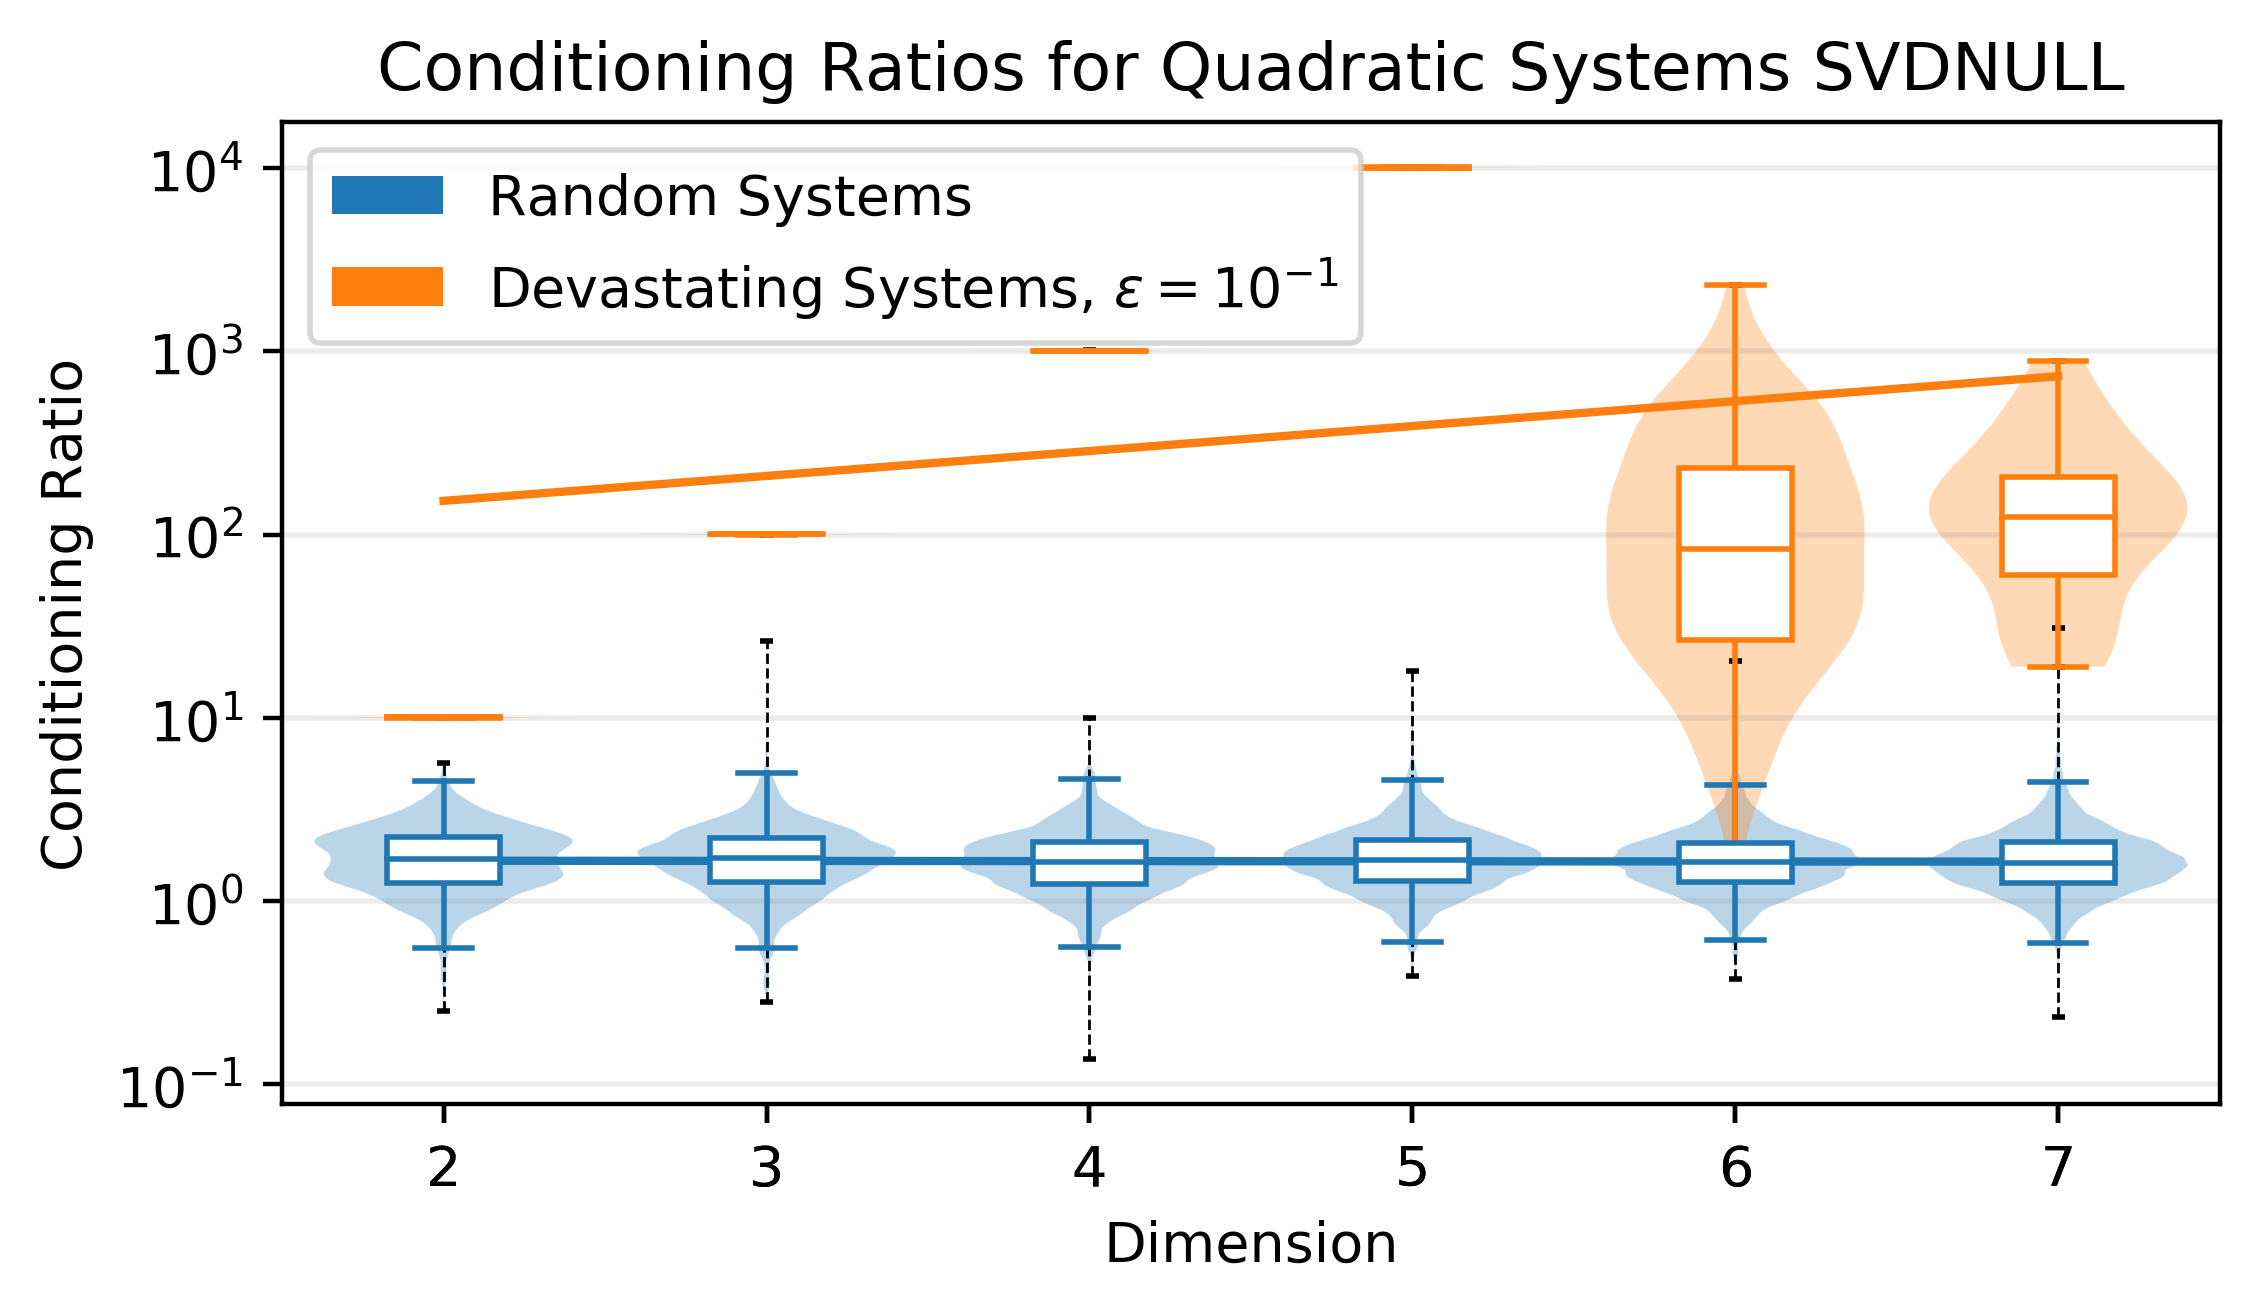

In [8]:
plot([rand_svdfastnull,dev_svdfastnull],
     ['Random Systems',r'Devastating Systems, $\epsilon=10^{-1}$'],
     figsize=(6.25,3.25), filename='rand_dev_svdfastnull', title='Conditioning Ratios for Quadratic Systems SVDNULL')

Random Systems
Slope: -0.0009860648746192148 
Growth Rate: -0.002267922649492271

Devastating Systems, $\epsilon=10^{-1}$
Slope: 1.0000715228480788 
Growth Rate: 9.001647010055162



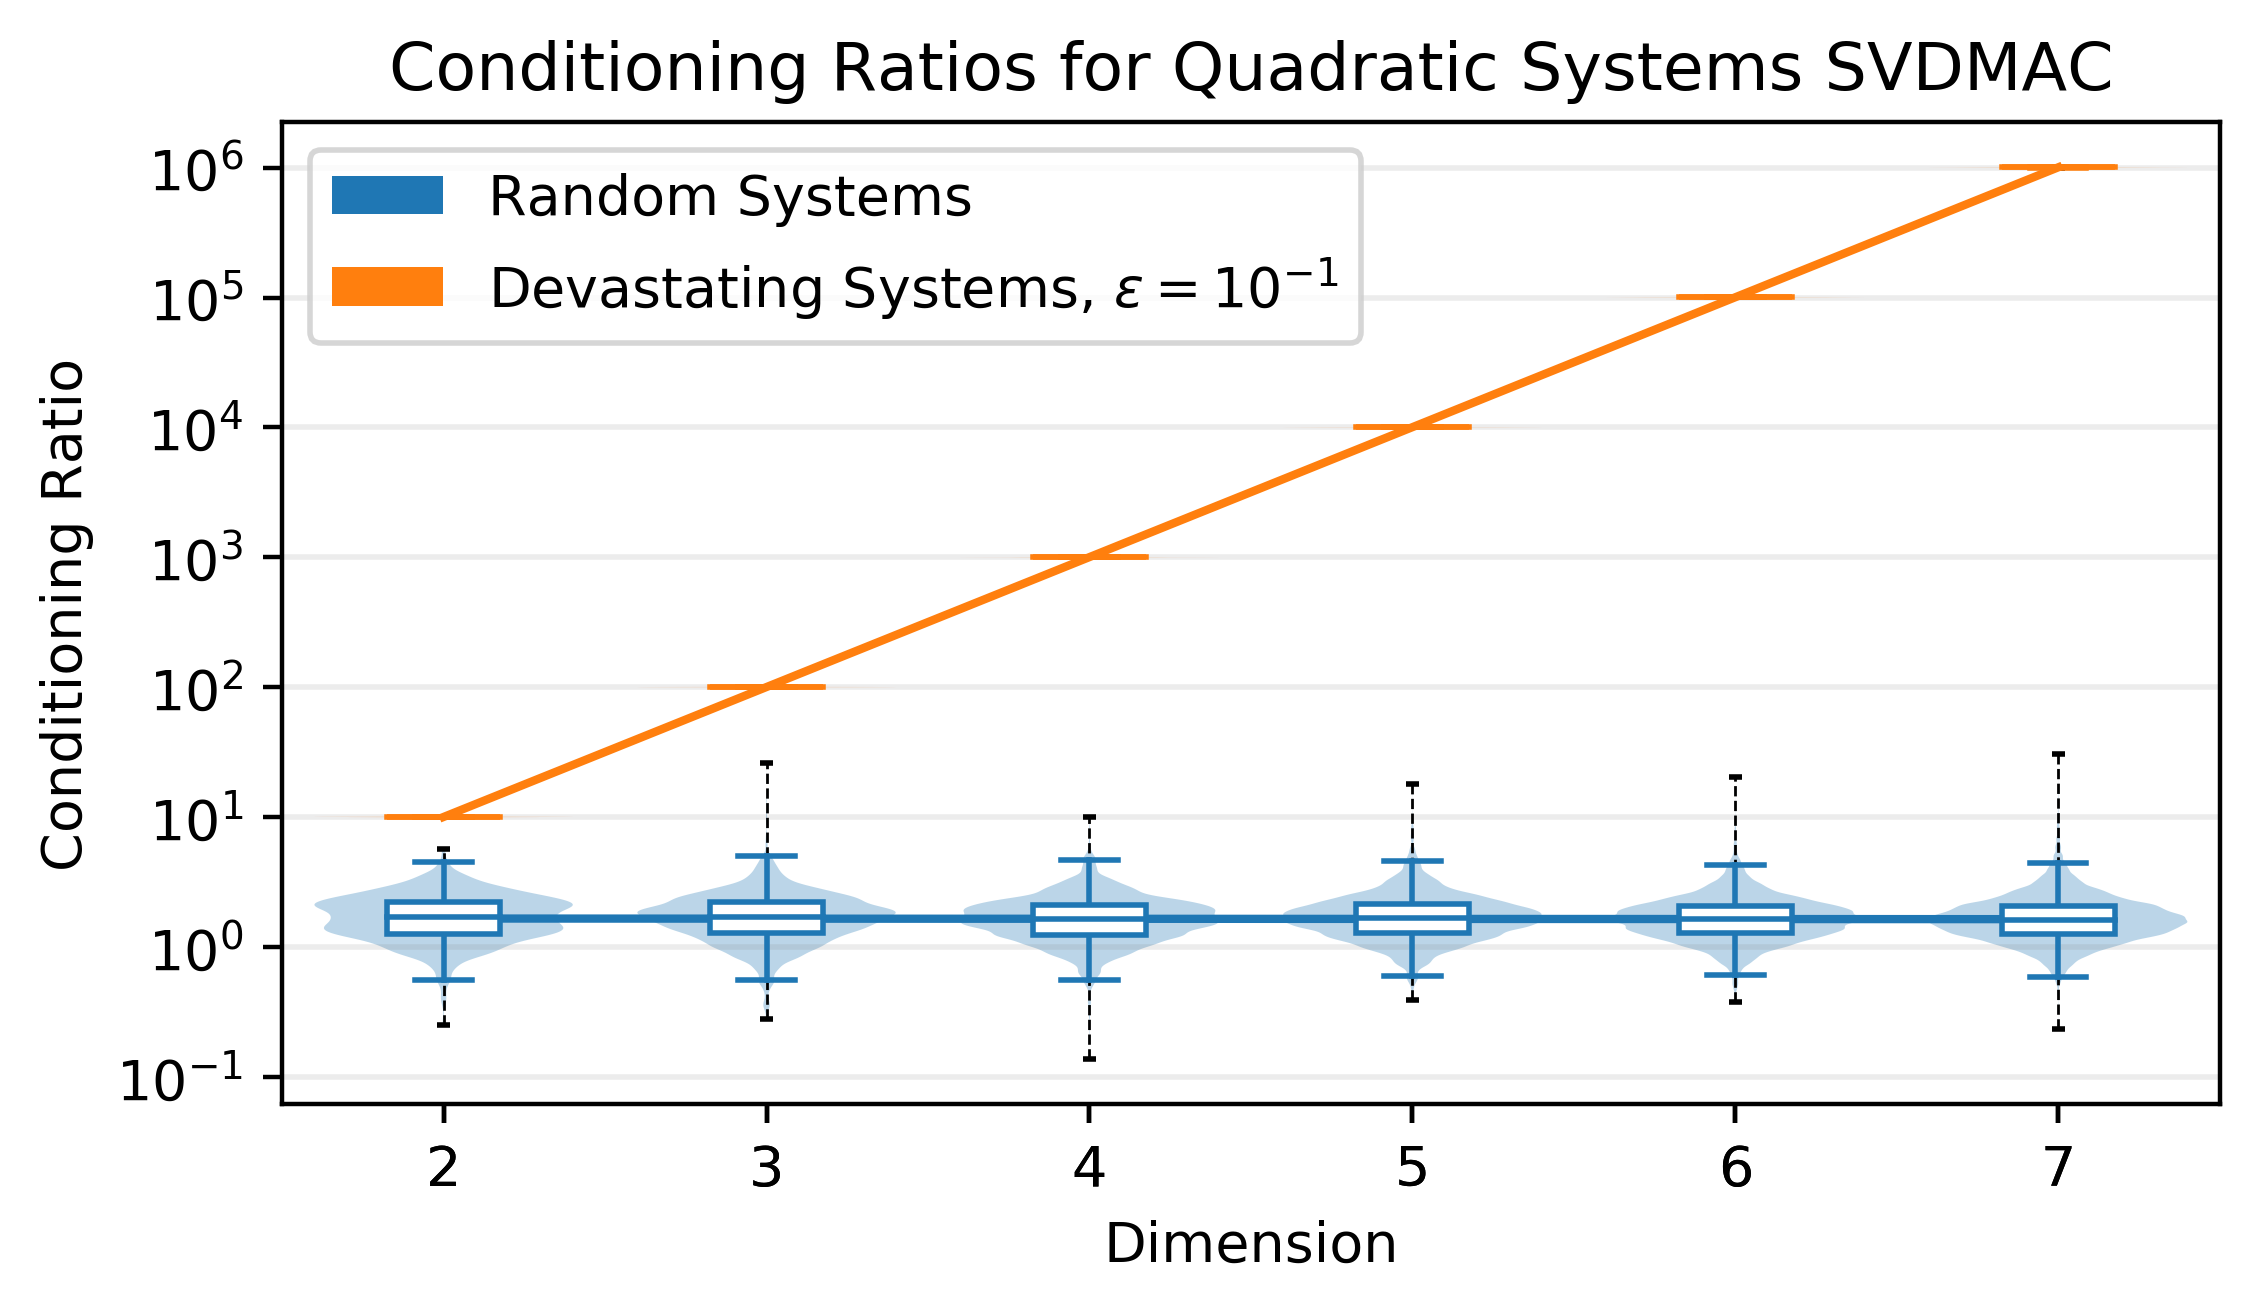

In [9]:
plot([rand_svdmac,dev_svdmac],
     ['Random Systems',r'Devastating Systems, $\epsilon=10^{-1}$'],
     figsize=(6.25,3.25), filename='rand_dev_svdmac', title='Conditioning Ratios for Quadratic Systems SVDMAC')

Random Systems
Slope: 0.13361753338093943 
Growth Rate: 0.3602462377464337

Devastating Systems, $\epsilon=10^{-1}$
Slope: 0.3517695975869861 
Growth Rate: 1.2478617512190873



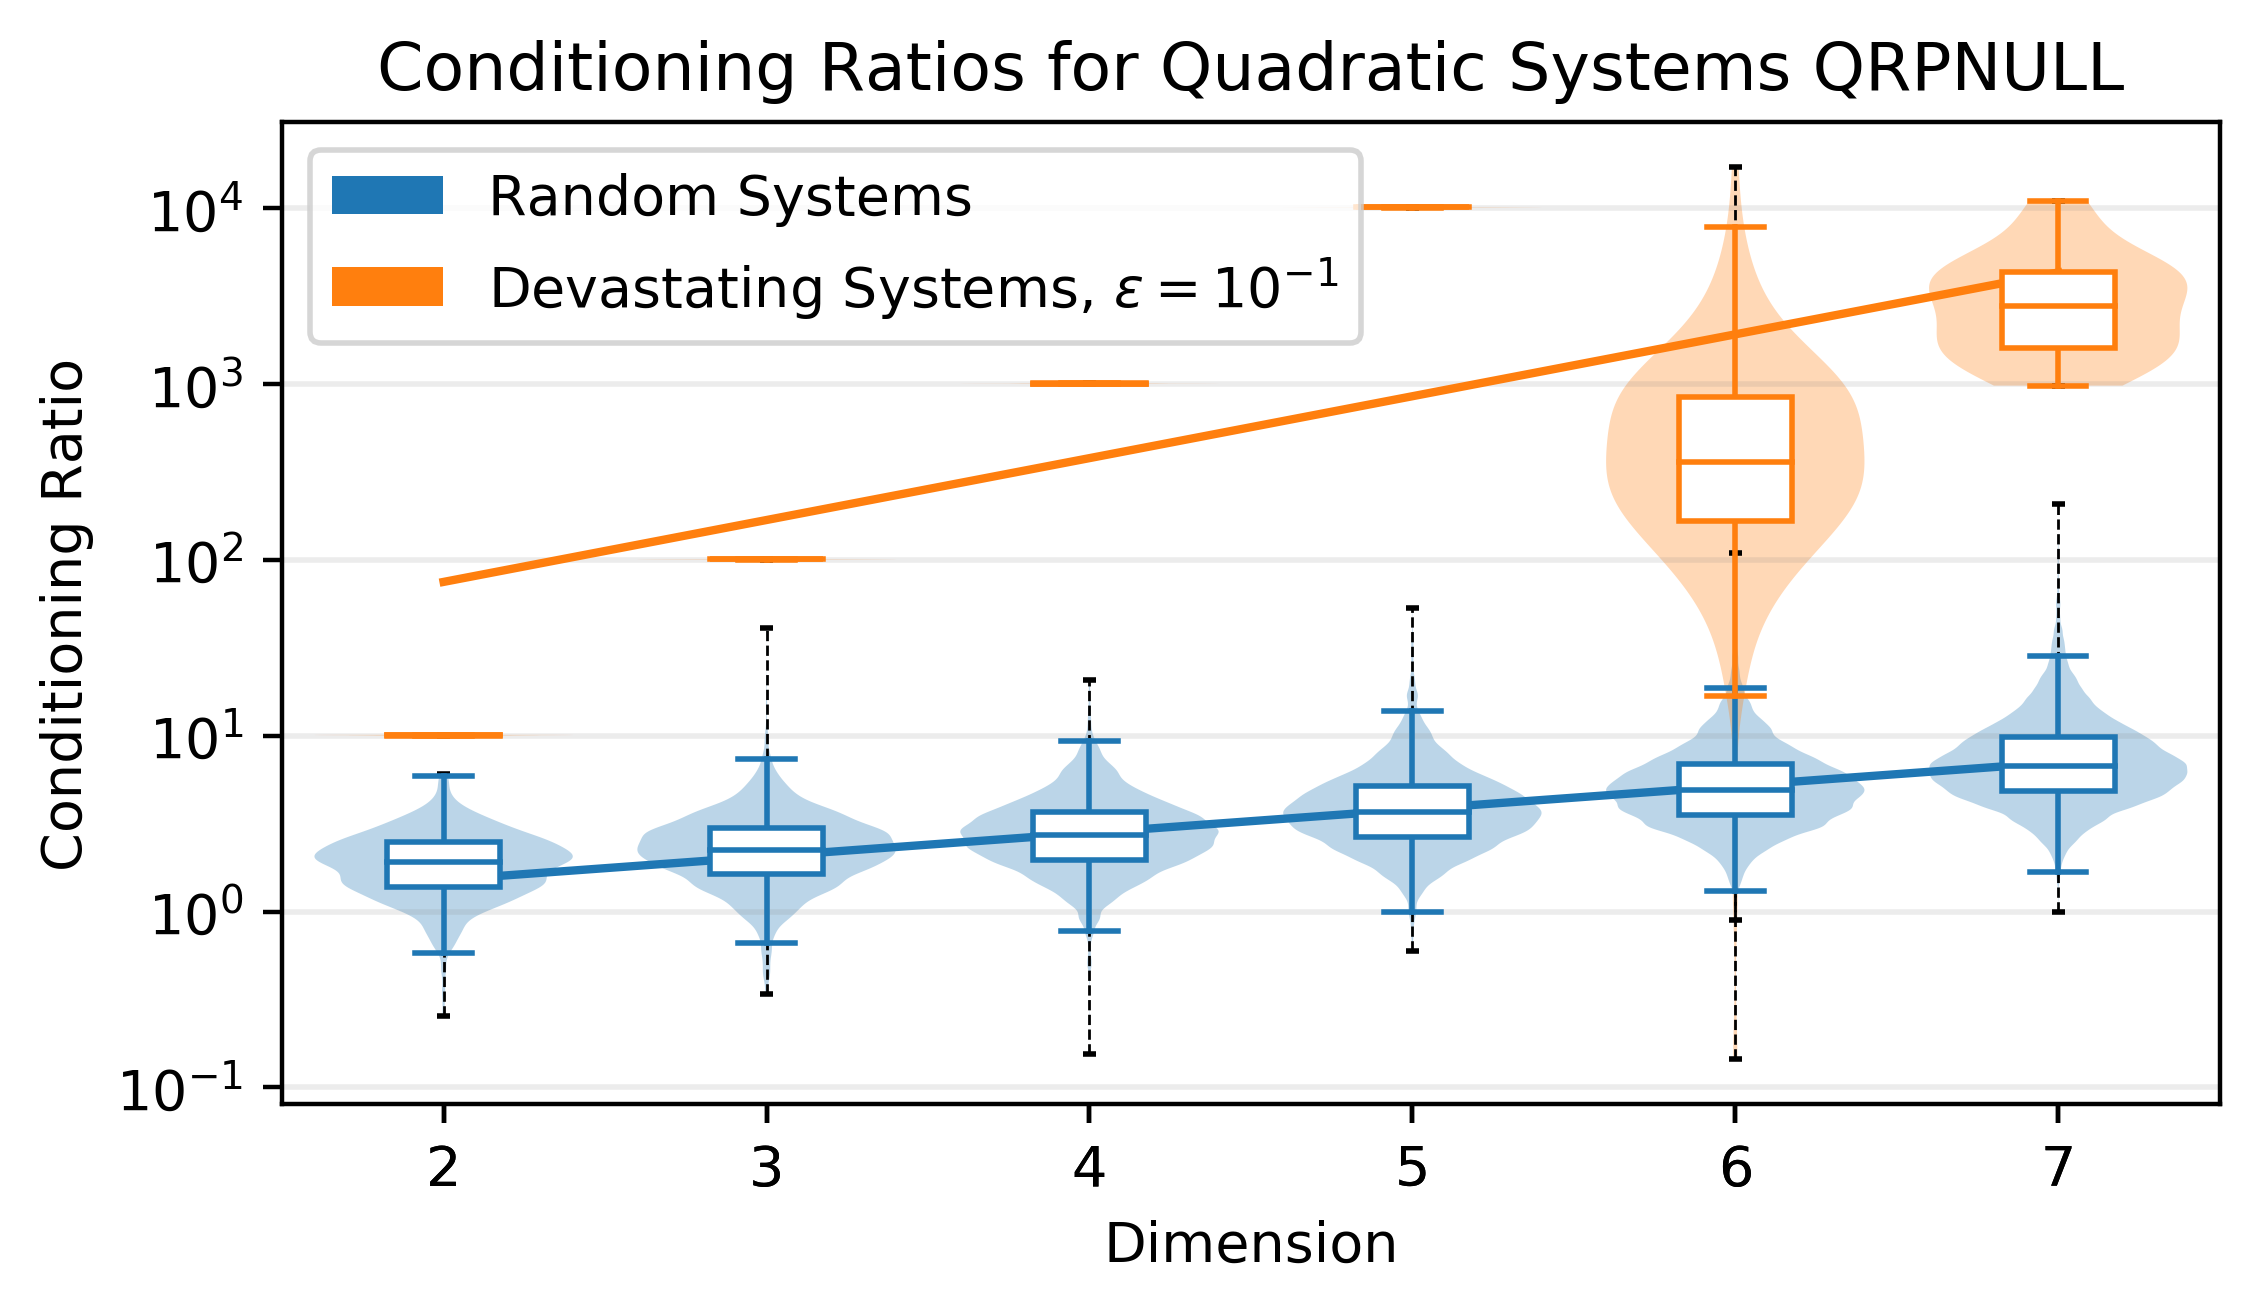

In [10]:
plot([rand_qrpfastnull,dev_qrpfastnull],
     ['Random Systems',r'Devastating Systems, $\epsilon=10^{-1}$'],
     figsize=(6.25,3.25), filename='rand_dev_qrpnull', title='Conditioning Ratios for Quadratic Systems QRPNULL')

Random Systems
Slope: 0.13361753338093943 
Growth Rate: 0.3602462377464337

Devastating Systems, $\epsilon=10^{-1}$
Slope: 1.0001456219047988 
Growth Rate: 9.00335363048821



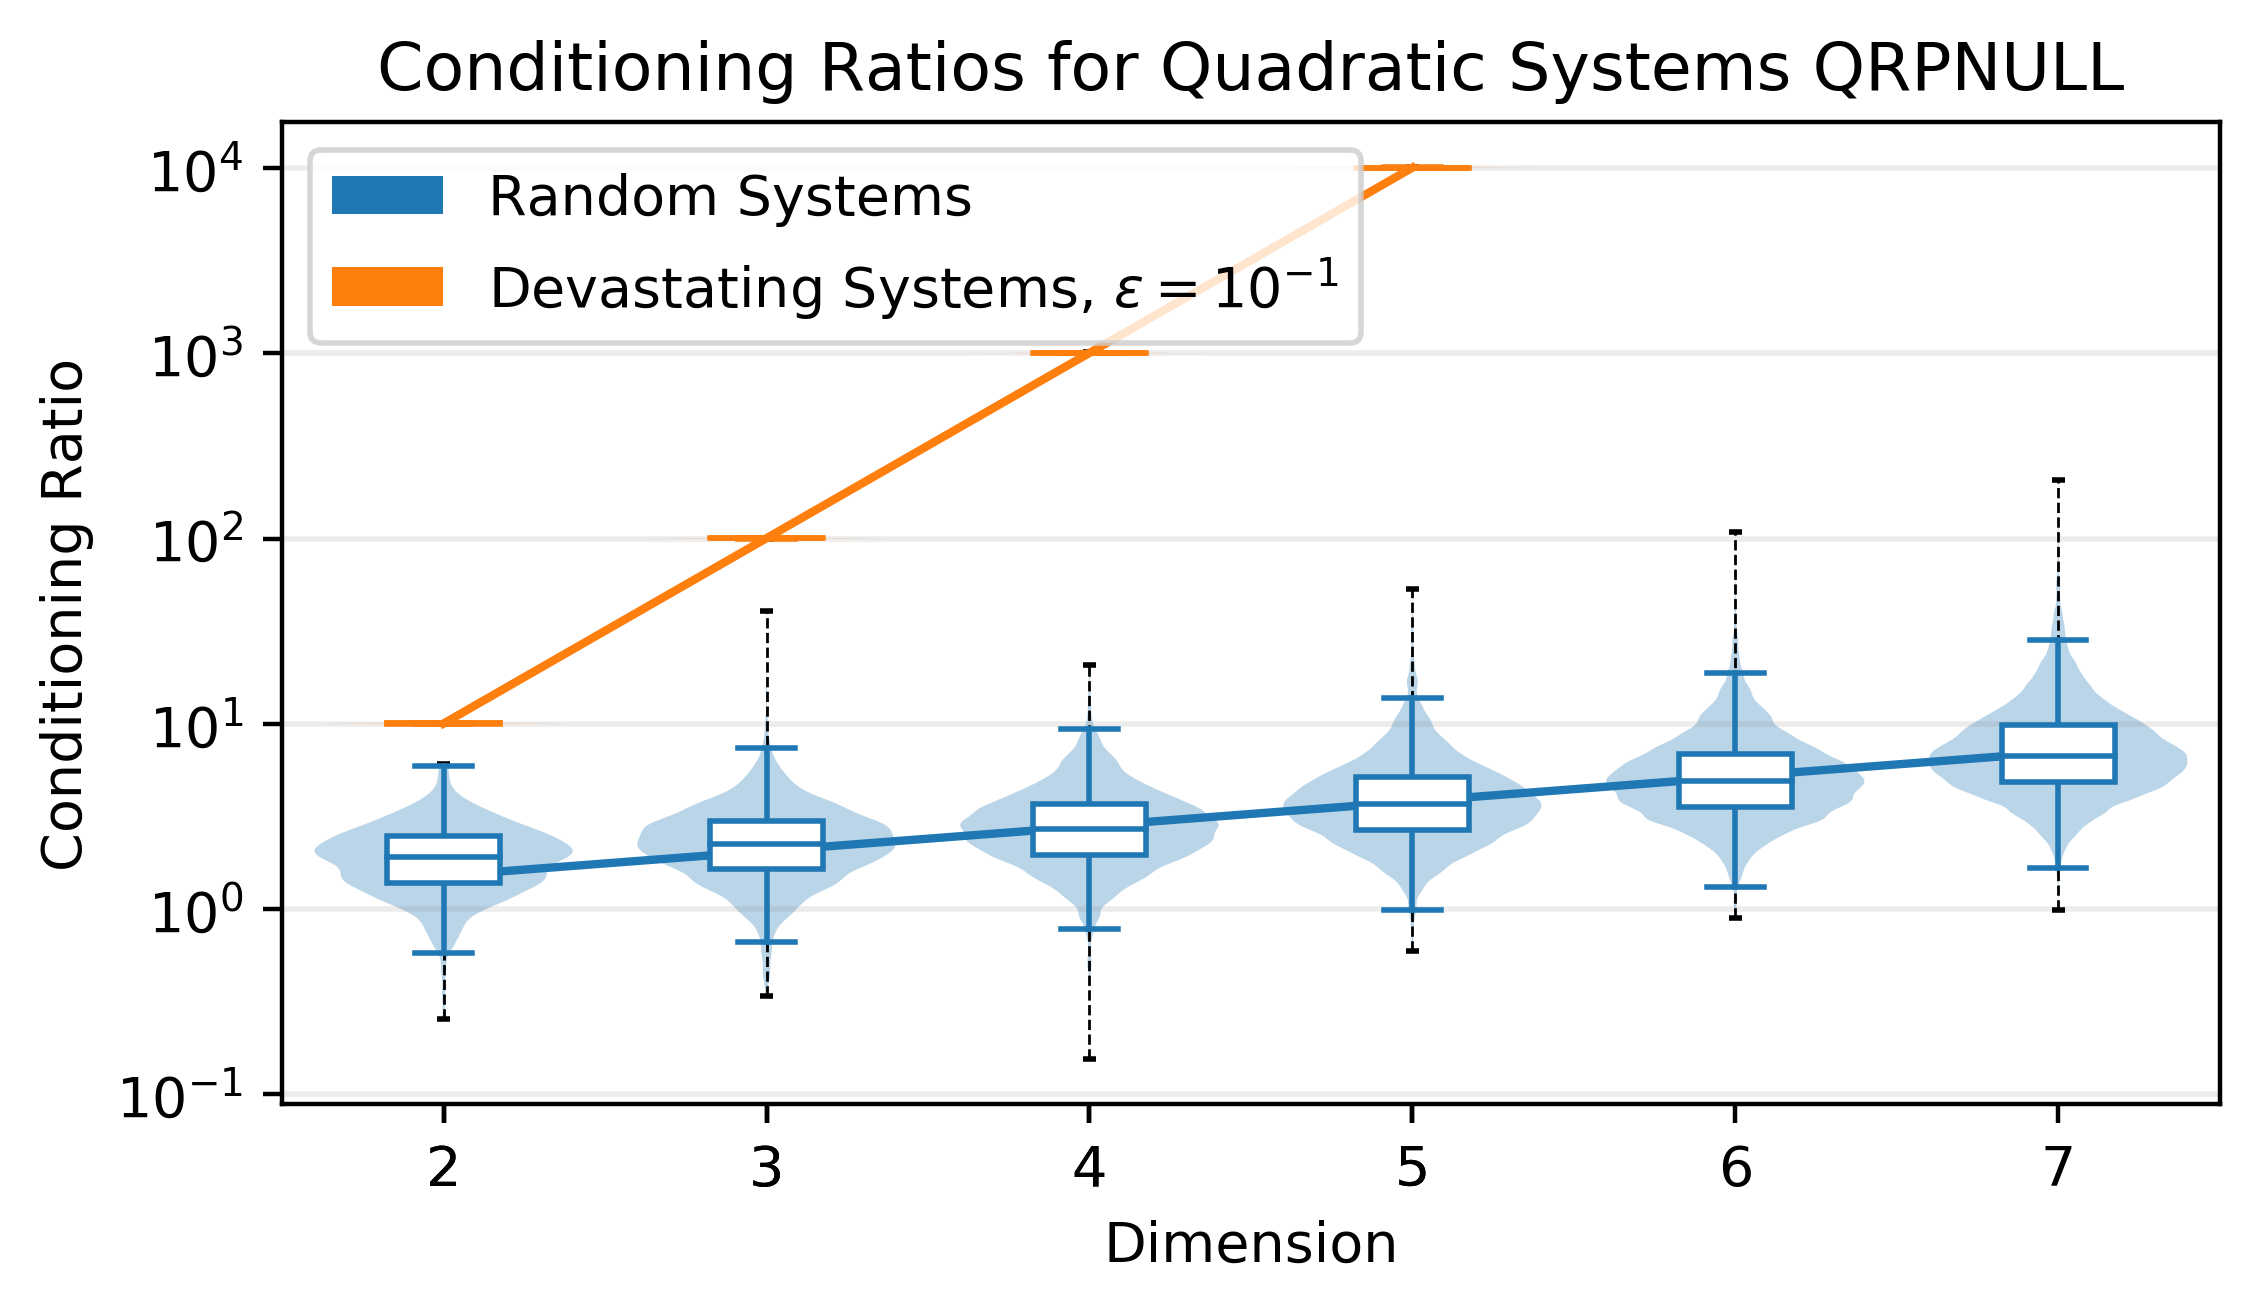

In [11]:
plot([rand_qrpfastnull,
      {d:dev_qrpfastnull[d] for d in range(2,6)}],
     ['Random Systems',r'Devastating Systems, $\epsilon=10^{-1}$'],
     figsize=(6.25,3.25), filename='rand_dev', title='Conditioning Ratios for Quadratic Systems QRPNULL')

Numerically calculated conditioning ratios for devastating and random quadratic systems solved using the SVD method.  The conditioning ratios of random systems show very slow exponential growth in dimension compared to the devastating example. Orange: Line of best fit for conditioning ratios of $n$ dimensional devastating systems with a randomly chosen $Q$. All of the computed conditioning ratios were within $0.015\%$ of the theoretical value, and the computed growth rate was TODO. Blue: Random systems of quadratic polynomials with coefficients drawn from the standard normal distribution. The violin and box plots show the distributions of the conditioning ratios of theses systems. The dotted black lines represent the tail ends of these distributions out to the most extreme observed conditioning ratios. The line of best fit to the base-10 logarithm of the conditioning ratios is also shown, with a growth rate of $r \approx TODO$.

# Perturbing the Devastating Example
Perturbation of the devastating example seems to slow the exponential increase in conditioning ratio. To explore this numerically, we perturbed devastating systems by adding a random quadratic polynomial with coefficients drawn from a normal distribution with standard deviation $\delta$. Larger perturbations correspond to slower exponential growth in conditioning ratio. This behavior occurs because perturbation of the problem creates a dense system, which opens up more choices for the basis of $\mathcal A$, and experimentally many of these newly available bases correspond to better conditioned eigenproblems.

For these experiments, we fix $\varepsilon = 10^{-2}$ and vary $\delta$ from $10^{-6}$ to $10^{-1}$. We generate a devastating example (i.e. choose a random $Q$) in each dimension (2,3,4 and 5) several times, and compute the conditioning ratio of the eigenvalues associated with the root at the origin.

The function `devastating_conditioning_ratios` returns a dictionary where the keys are the dimensions and values are arrays of shape `(numtests,dim)`. Those arrays contain the condition ratio for each coordinate of each root.

The plotting function will plot violin/box plots of the data in each dimension and a line of best fit through the data. It will also print out the slope of the line of best fit and the exponential growth rate.

In [12]:
dev_2_delta = []
deltas = [0,.00001,.0001,.001,.01,.1]
methods = ['svdmac','svdfastnull','svdnull','qrpfastnull']
for method in methods:
    method_res = []
    for delta in deltas:
        print(delta)
        res = devastating_conditioning_ratios([2,3,4,5],
                                              eps=.01,
                                              delta=delta,
                                              kind='power',
                                              numtests=50,
                                              newton=True,
                                              method=method,
                                              save=False)
        method_res.append(res)
    dev_2_delta.append(method_res)

0
1e-05
0.0001
0.001
0.01
0.1
0
1e-05
0.0001
0.001
0.01
0.1
0
1e-05
0.0001
0.001
0.01
0.1
0
1e-05
0.0001
0.001
0.01
0.1


$\epsilon=10^{-2}$
Slope: 1.9999999684301986 
Growth Rate: 98.99999273078484

$\epsilon=10^{-2}, \delta=10^{-5}$
Slope: 1.9937309790381132 
Growth Rate: 97.56687302440619

$\epsilon=10^{-2}, \delta=10^{-4}$
Slope: 1.7410034162275723 
Growth Rate: 54.08120291609845

$\epsilon=10^{-2}, \delta=10^{-3}$
Slope: 1.2985365292239608 
Growth Rate: 18.88550063582778

$\epsilon=10^{-2}, \delta=10^{-2}$
Slope: 0.8021768824008879 
Growth Rate: 5.3412793059133685

$\epsilon=10^{-2}, \delta=10^{-1}$
Slope: 0.2343819610344589 
Growth Rate: 0.7154653922437155



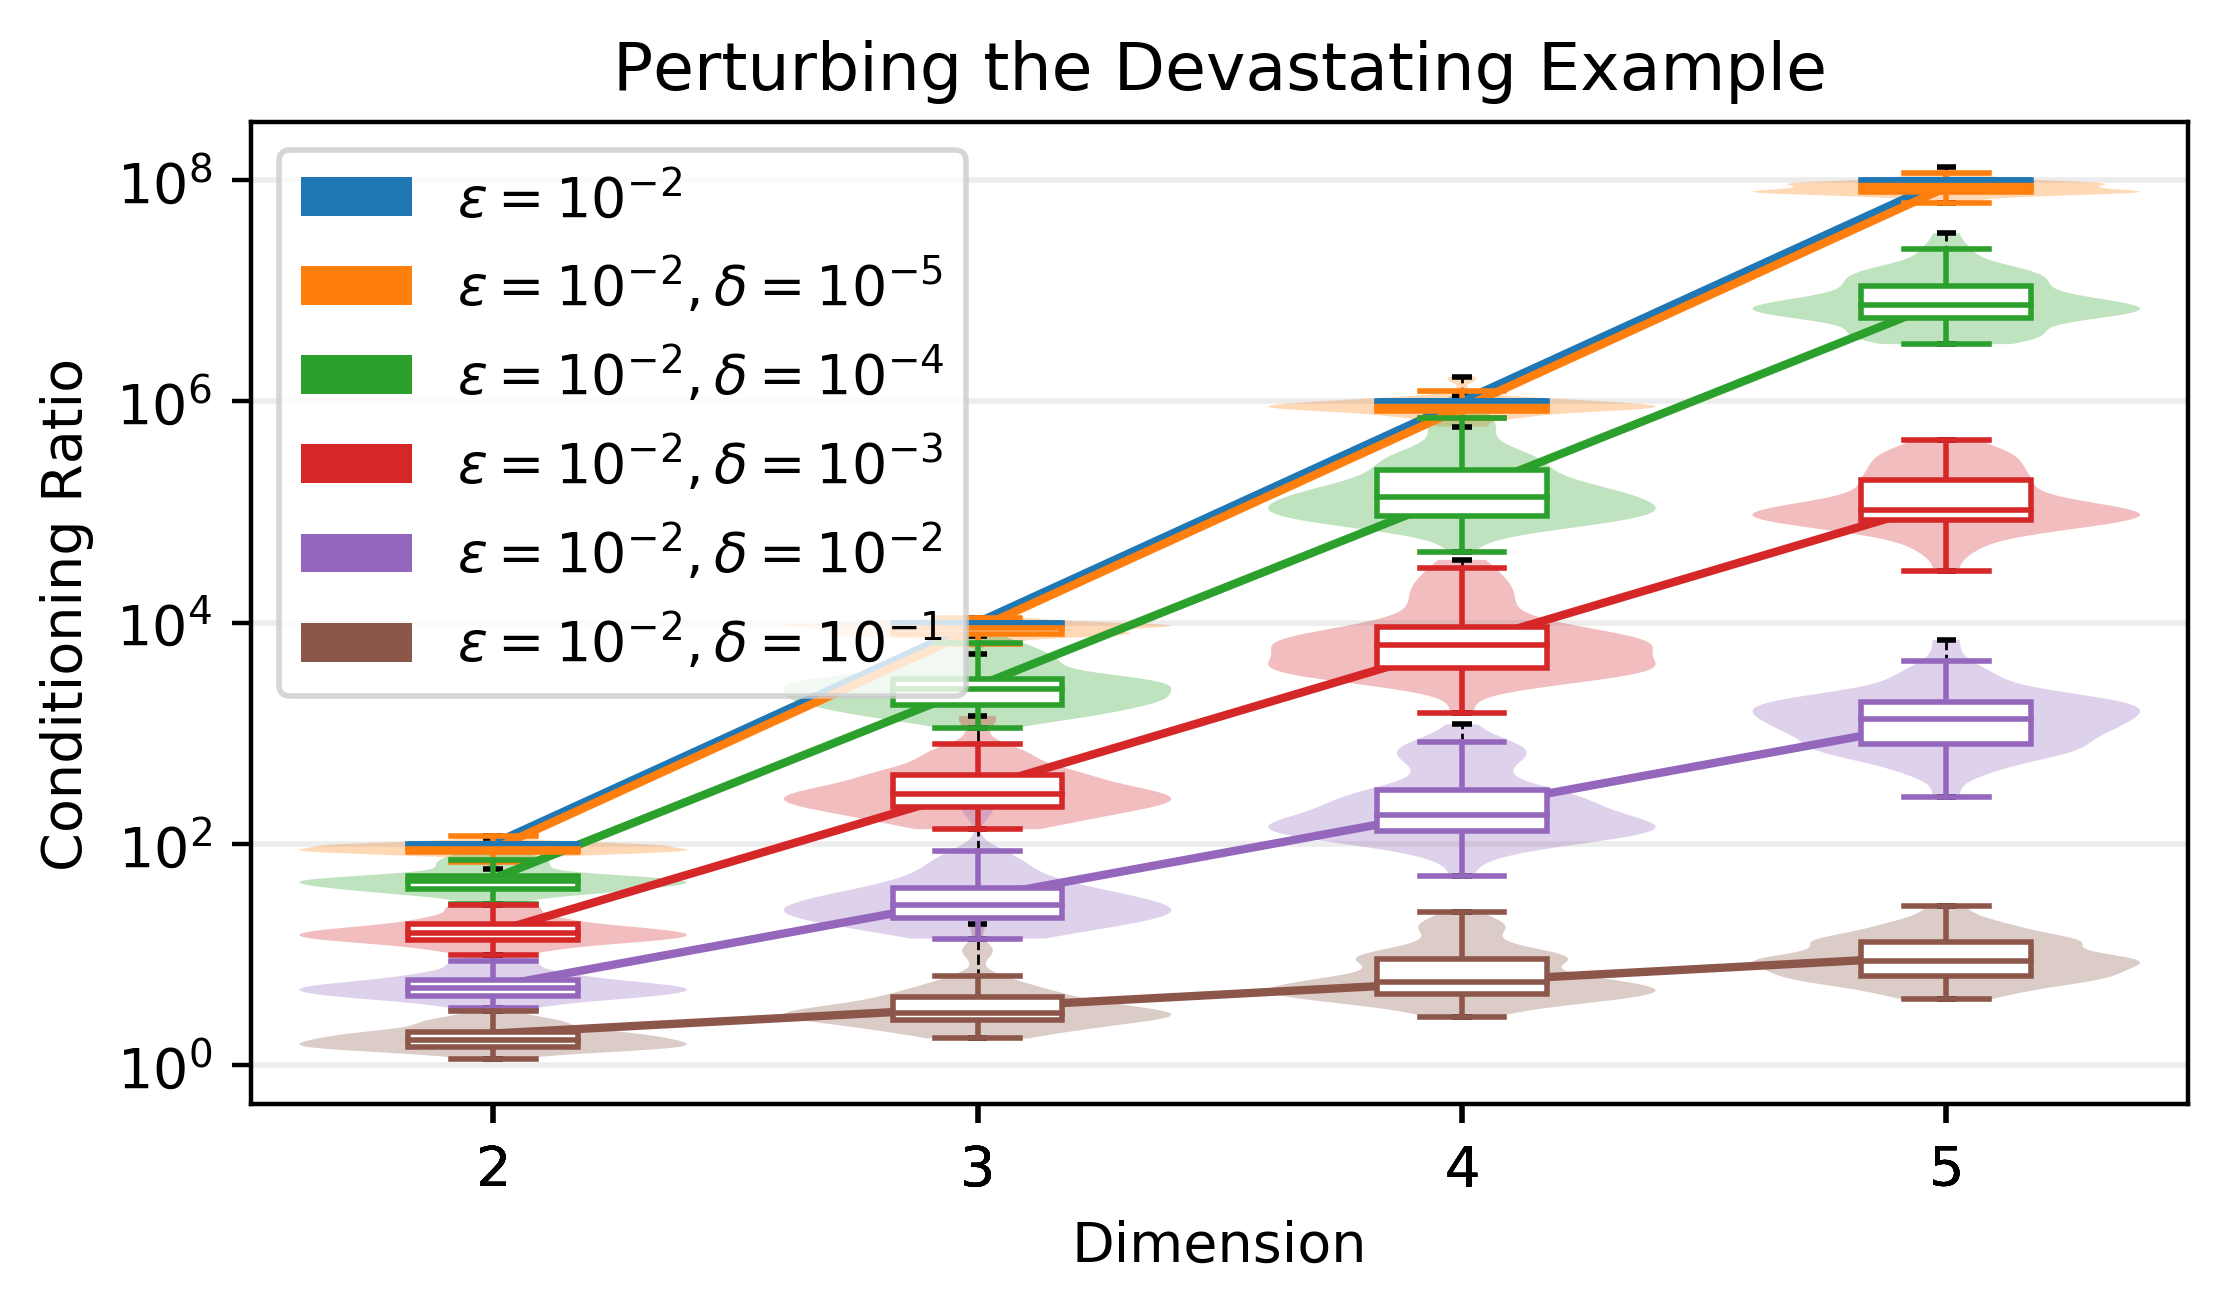

$\epsilon=10^{-2}$
Slope: 1.9999337854418295 
Growth Rate: 98.98475469675623

$\epsilon=10^{-2}, \delta=10^{-5}$
Slope: 1.9932799227746905 
Growth Rate: 97.4645550633859

$\epsilon=10^{-2}, \delta=10^{-4}$
Slope: 1.7410104349453506 
Growth Rate: 54.08209310134887

$\epsilon=10^{-2}, \delta=10^{-3}$
Slope: 1.2985366170688863 
Growth Rate: 18.885504658076673

$\epsilon=10^{-2}, \delta=10^{-2}$
Slope: 0.8021768825464279 
Growth Rate: 5.341279308038447

$\epsilon=10^{-2}, \delta=10^{-1}$
Slope: 0.23438196103443373 
Growth Rate: 0.715465392243616



<Figure size 432x288 with 0 Axes>

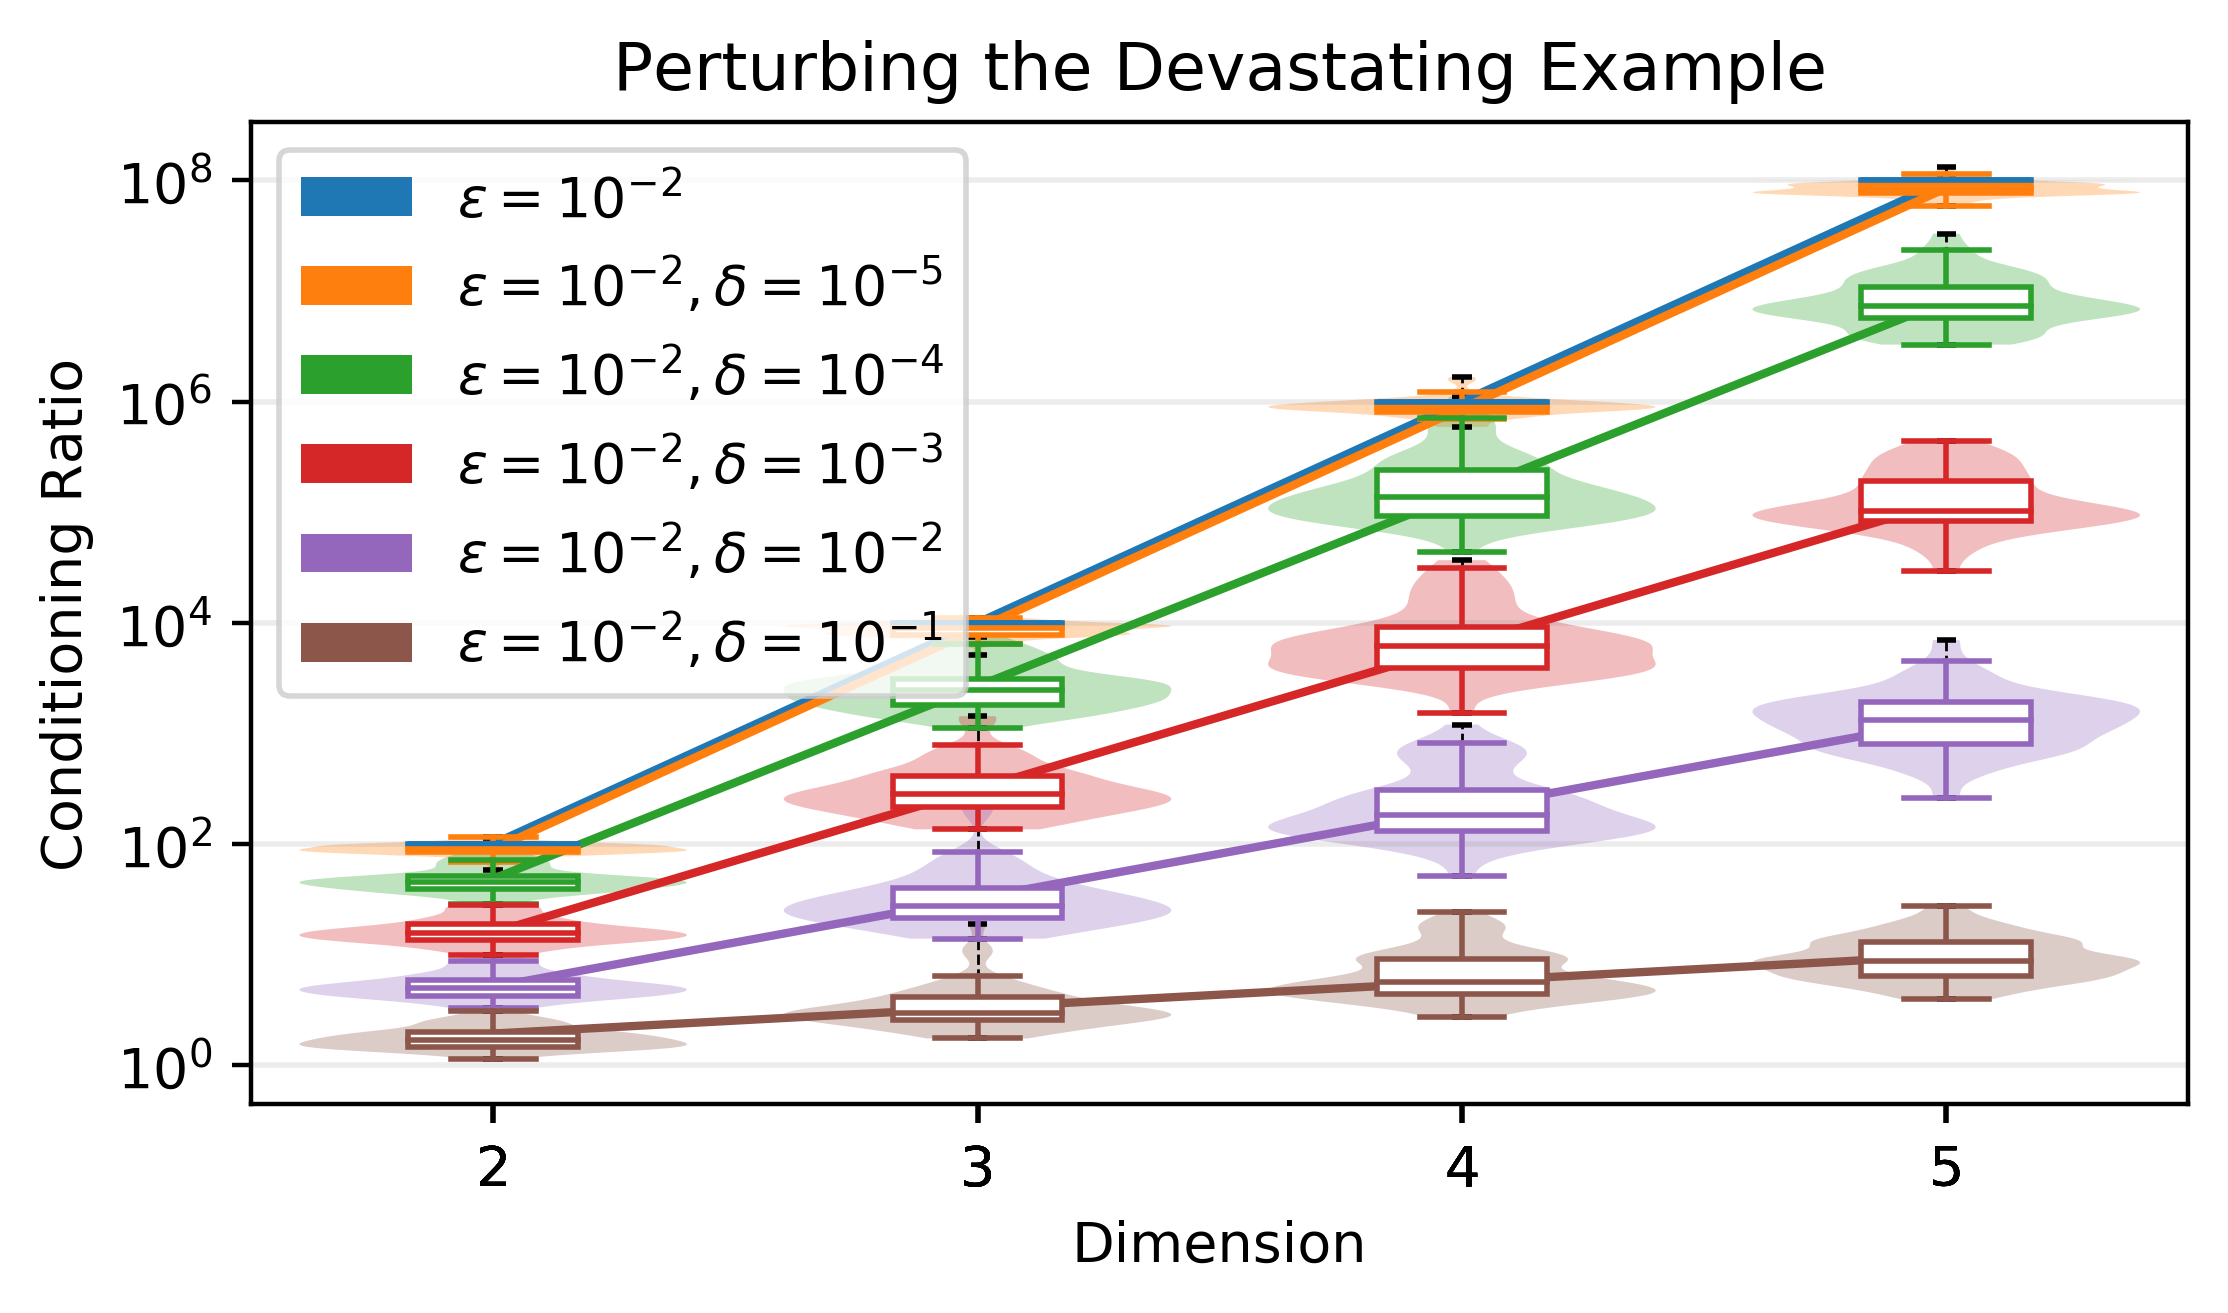

$\epsilon=10^{-2}$
Slope: 1.9999994876958092 
Growth Rate: 98.99988203767029

$\epsilon=10^{-2}, \delta=10^{-5}$
Slope: 1.9942375795254148 
Growth Rate: 97.68191745417577

$\epsilon=10^{-2}, \delta=10^{-4}$
Slope: 1.7410025919663796 
Growth Rate: 54.08109837584566

$\epsilon=10^{-2}, \delta=10^{-3}$
Slope: 1.2985365206216382 
Growth Rate: 18.88550024194414

$\epsilon=10^{-2}, \delta=10^{-2}$
Slope: 0.8021768823736647 
Growth Rate: 5.341279305515873

$\epsilon=10^{-2}, \delta=10^{-1}$
Slope: 0.23438196103444936 
Growth Rate: 0.7154653922436778



<Figure size 432x288 with 0 Axes>

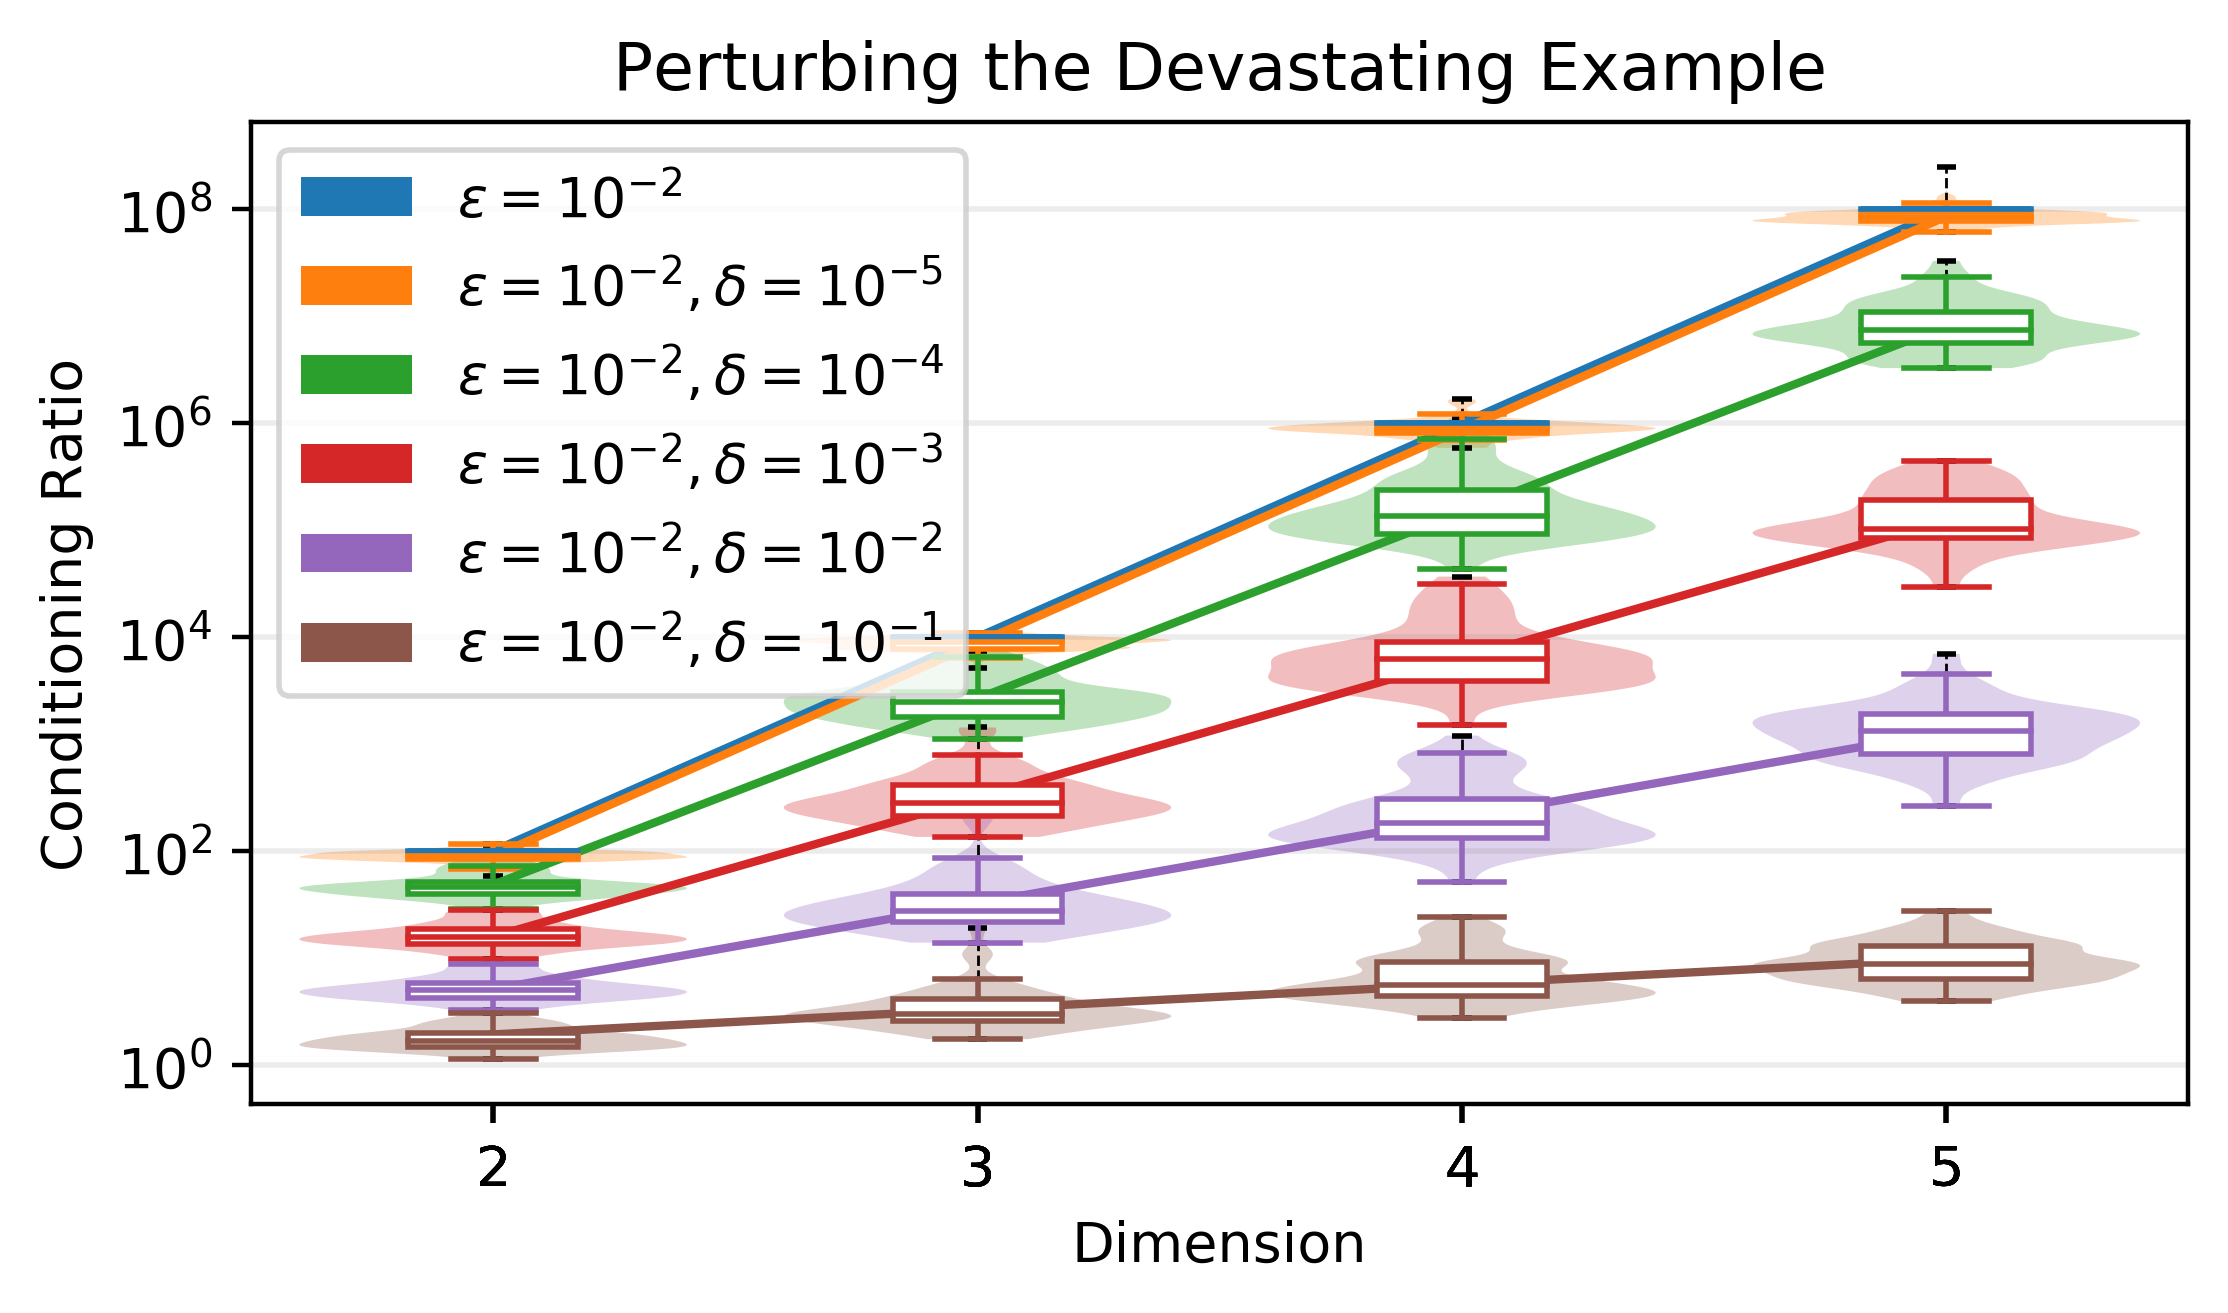

$\epsilon=10^{-2}$
Slope: 1.999933738773969 
Growth Rate: 98.98474395272304

$\epsilon=10^{-2}, \delta=10^{-5}$
Slope: 1.9932840907174696 
Growth Rate: 97.46550003648059

$\epsilon=10^{-2}, \delta=10^{-4}$
Slope: 1.741010387716974 
Growth Rate: 54.08208711131722

$\epsilon=10^{-2}, \delta=10^{-3}$
Slope: 1.2985400682858126 
Growth Rate: 18.885662683255006

$\epsilon=10^{-2}, \delta=10^{-2}$
Slope: 0.8025139683812147 
Growth Rate: 5.346203121913301

$\epsilon=10^{-2}, \delta=10^{-1}$
Slope: 0.2658546116824513 
Growth Rate: 0.844397868637158



<Figure size 432x288 with 0 Axes>

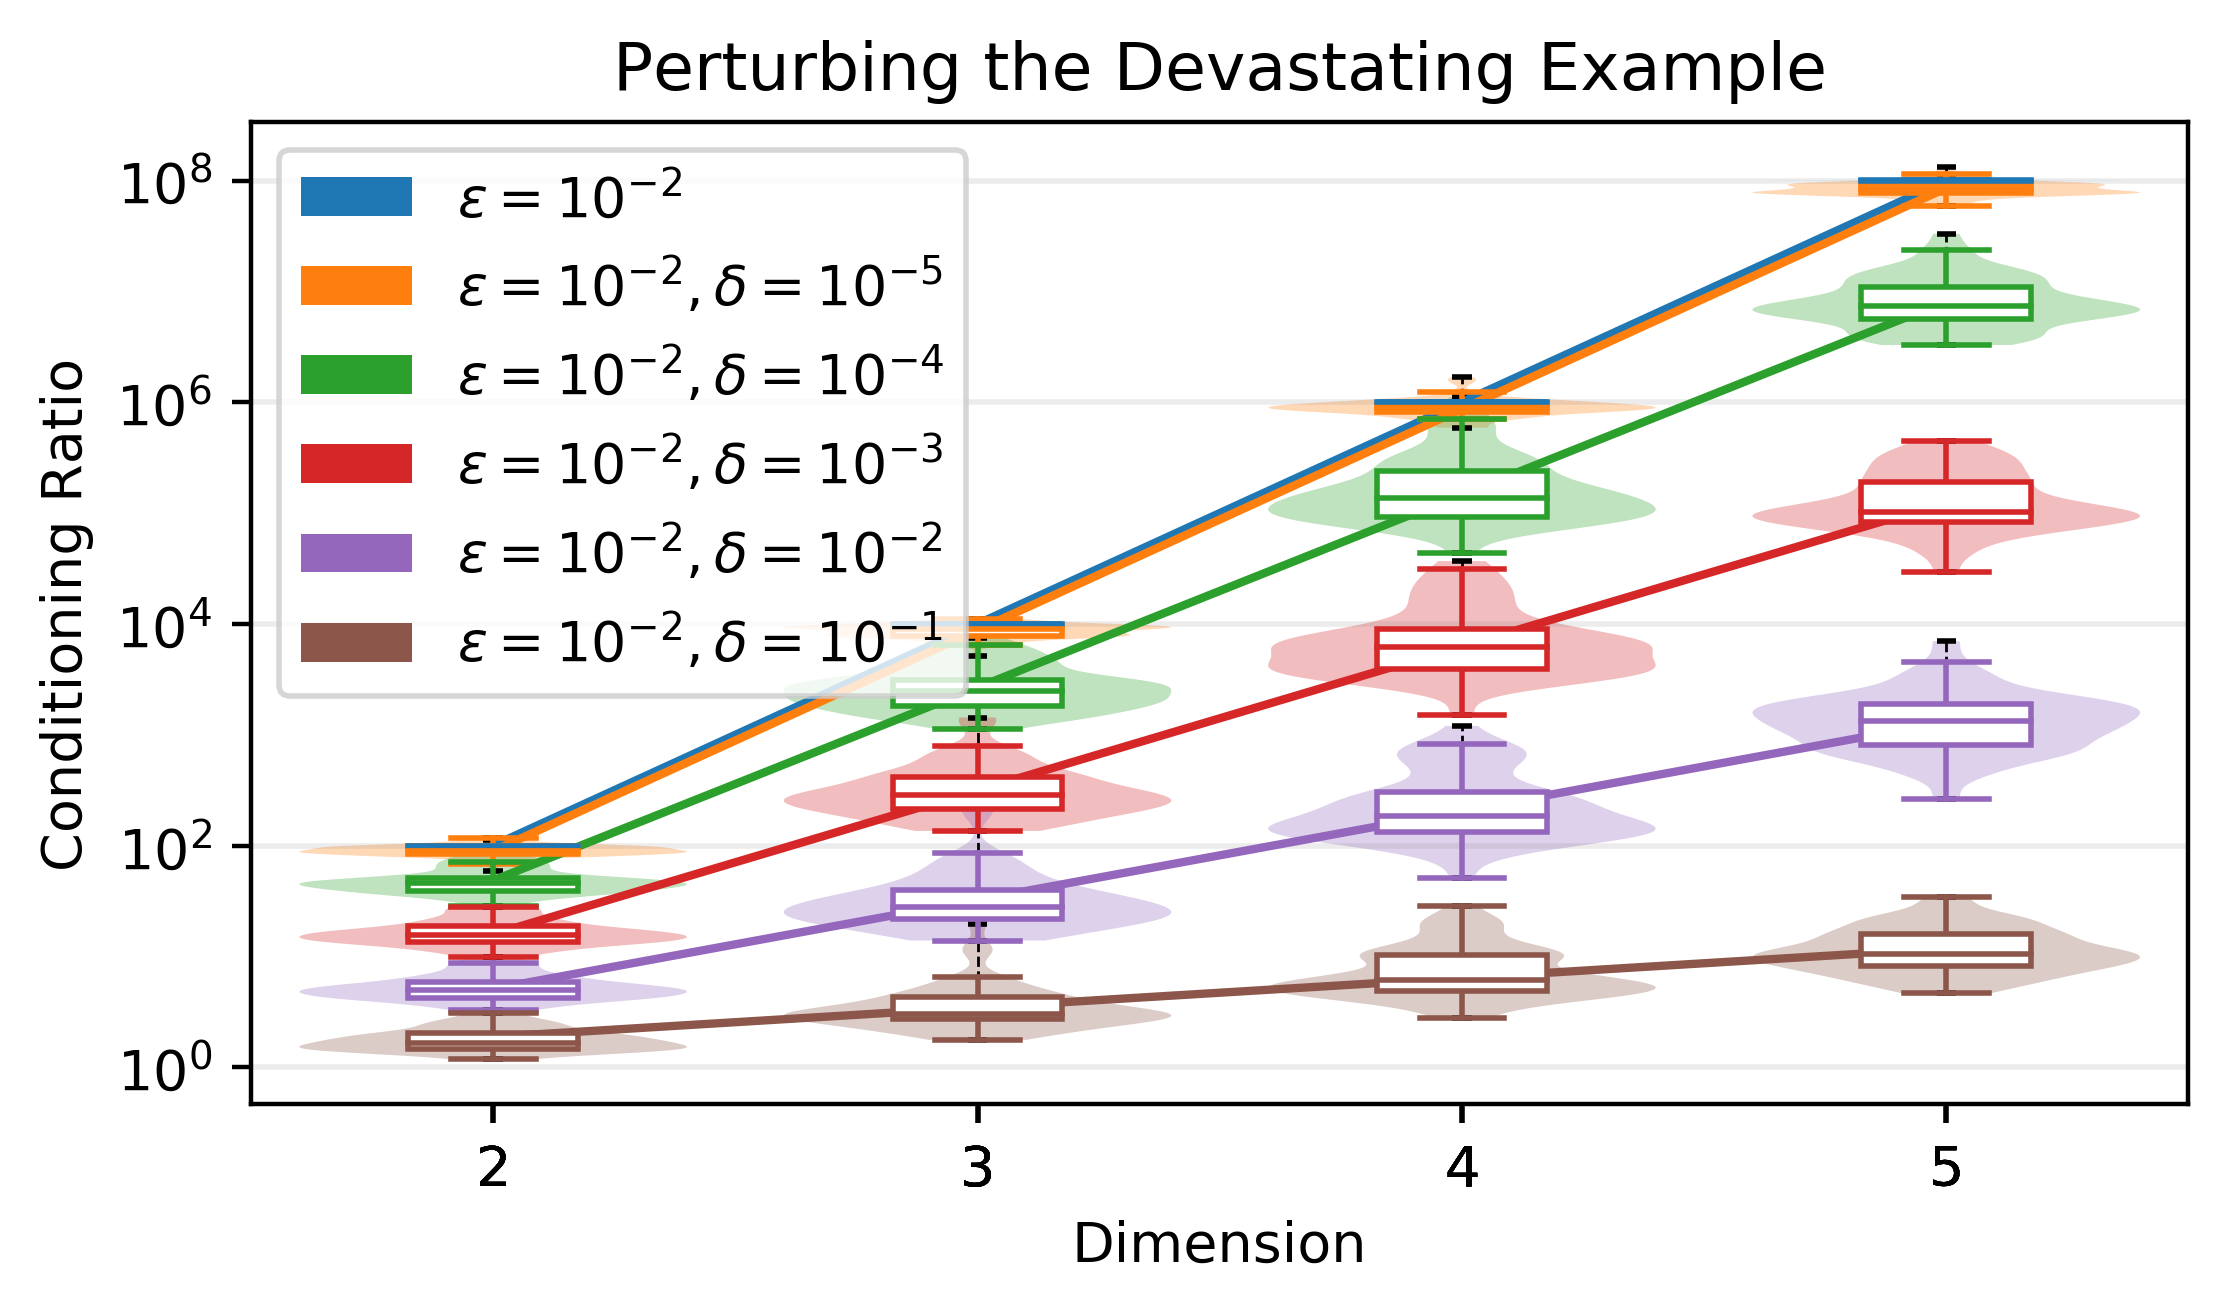

<Figure size 432x288 with 0 Axes>

In [13]:
labels = [r'$\epsilon=10^{-2}$',
      r'$\epsilon=10^{-2}, \delta=10^{-5}$',
      r'$\epsilon=10^{-2}, \delta=10^{-4}$',
      r'$\epsilon=10^{-2}, \delta=10^{-3}$',
      r'$\epsilon=10^{-2}, \delta=10^{-2}$',
      r'$\epsilon=10^{-2}, \delta=10^{-1}$']
for method in dev_2_delta:
    plot(method,labels,
         title='Perturbing the Devastating Example',
         figsize=(6.25,3.25), filename='perturbed')
    plt.clf()

From this plot we can see that the slopes of the lines of best fit, which are directly related to the growth rates, decrease as $\delta$ increases. To explore this further, we compute the slopes for more values of $\delta$ between $10^{-6}$ and $10^{-1}$. The code below is a little slow to run, but it is how we generated the `slopes` array. Newton polishing the root changes very little in this test but takes some time, so we did not Newton polish the roots for this test.

```
deltas,slopes = [],[]
for delta in np.logspace(-6,-1):
    print('delta =',delta,end='\r')
    data = devastating_conditioning_ratios([2,3,4,5],.01,
                                      'power',
                                      newton=False,
                                      save=False,
                                      delta=delta)
    data_log10 = [np.log10(data[d].flatten()) for d in data.keys()]
    points = np.array([[d,val] for i,d in enumerate(data.keys()) for val in data_log10[i]])
    slope = linregress(points)[0]
    deltas.append(delta)
    slopes.append(slope)
```

```
np.save('tests/conditioning_ratios/deltas.npy',deltas)
np.save('tests/conditioning_ratios/deltaslopes.npy',slopes)
```

In [14]:
deltas = np.load('tests/conditioning_ratios/deltas.npy')
slopes = np.load('tests/conditioning_ratios/deltaslopes.npy')
#dding in a few data points from the computed data above
_slopes = [1.993731058425459, 1.741003395634404,1.29853652887252,0.8021768824007329,0.2343819610344608]
_deltas = [1e-5,1e-4,1e-3,1e-2,1e-1]
alldeltas = np.array(list(deltas) + _deltas)
allslopes = np.array(list(slopes) + _slopes)
srt = np.argsort(alldeltas)

$\delta=0$
Slope: 1.9999999684301986 
Growth Rate: 98.99999273078484

$\delta=10^{-4}$
Slope: 1.7410034162275723 
Growth Rate: 54.08120291609845

$\delta=10^{-3}$
Slope: 1.2985365292239608 
Growth Rate: 18.88550063582778

$\delta=10^{-2}$
Slope: 0.8021768824008879 
Growth Rate: 5.3412793059133685



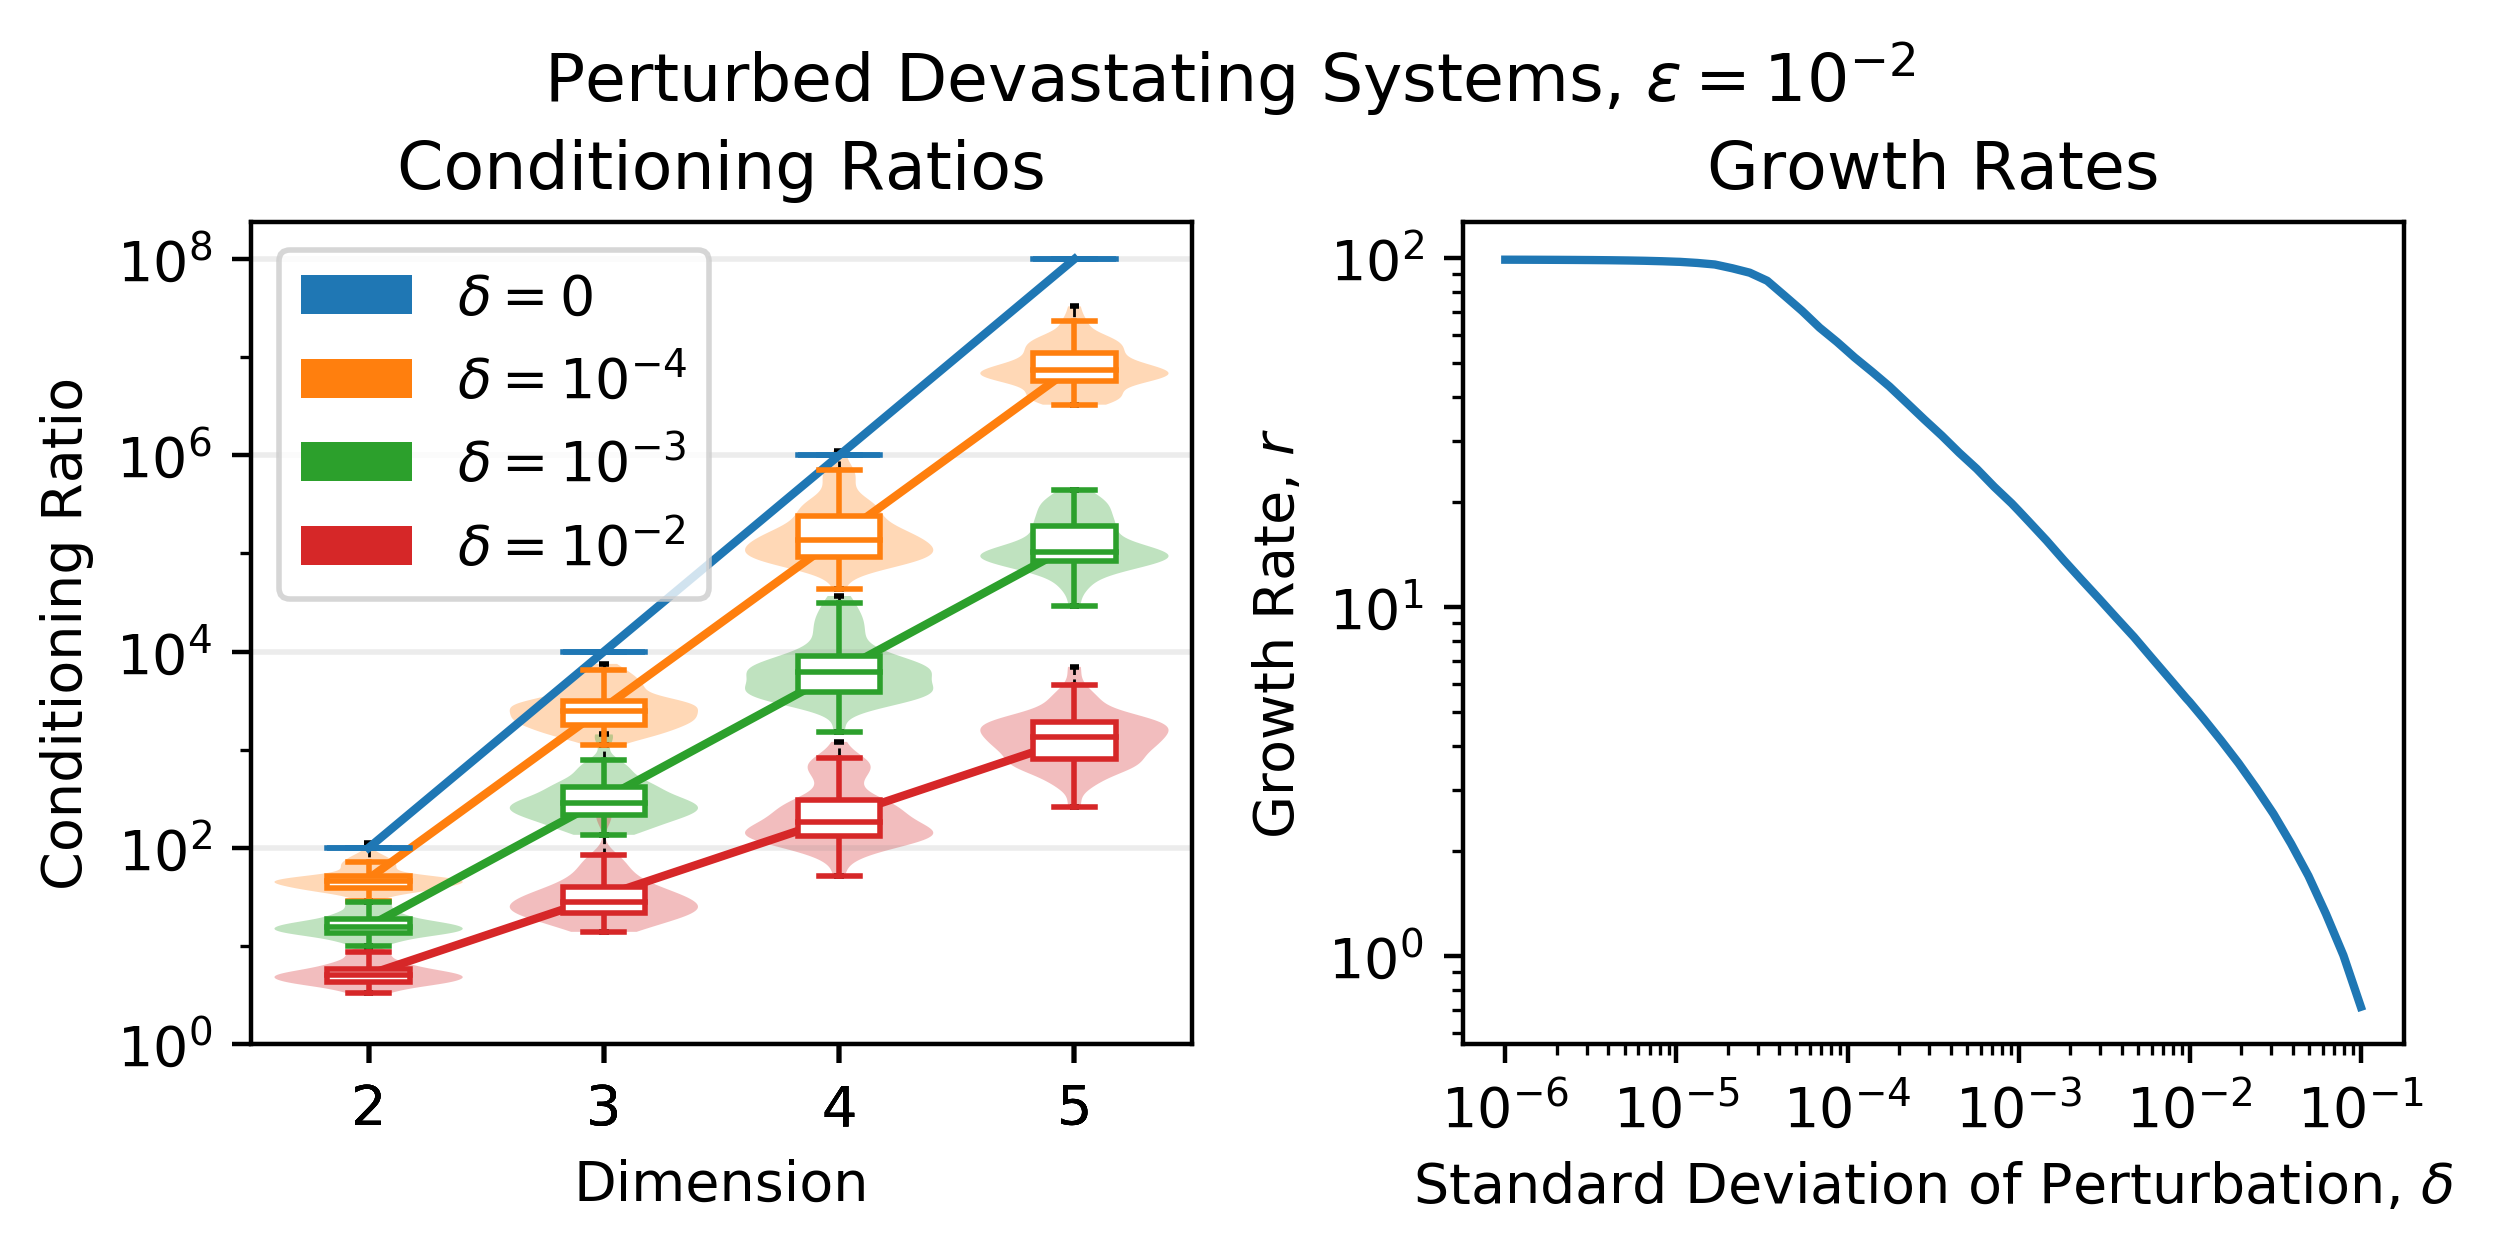

In [15]:
plot([dev_2_delta[0][0]]+dev_2_delta[0][2:-1],
     [r'$\delta=0$',
      r'$\delta=10^{-4}$',
      r'$\delta=10^{-3}$',
      r'$\delta=10^{-2}$'],
     figsize=(6.25,3.25), filename='perturbed_small_with_growth_rates', 
     title=['Conditioning Ratios','Growth Rates',r'Perturbed Devastating Systems, $\varepsilon=10^{-2}$'],
     subplots=[1,2], _2nd_plot=[alldeltas[srt],10**np.array(allslopes[srt])-1],
     min_ylim=0,max_ylim=9,_2nd_plot_axis_labels=['Standard Deviation of Perturbation, $\delta$','Growth Rate, $r$'])

We can see that for $\delta < 10^{-5}$, perturbing makes little difference in the growth rate, but the growth rate decreases for $\delta > 10^{-5}$.

# Generating Random Systems with Known Roots

The devastating example is close to a system with a very high multiplicity root. All of the roots of the system scale linearly with $\varepsilon$, so when $\varepsilon=0$, there is a root of order $2^n$. To better explore the behavior of M\"{o}ller-Stetter methods when roots are almost high multiplicity, we generate random systems of special quadratic polynomials for which it is easy to control the location of some of the roots. We then examine the behavior of the conditioning ratios when those roots are forced to be close together. In particular, we consider systems where each polynomial is of the form
$$f(\mathbf x) = 1 - \sum_{j=1}^n a_j(x_j - c_j)^2.$$
In two dimensions, this results in zero loci that are either hyperbolas or ellipses with axes along the coordinate directions. To force $\mathbf {r_1,\ldots,r_n}$ to be roots with $\mathbf{r}_i = (r_{i1},\ldots,r_{in})$ for all $i$, one can simply choose a center $\mathbf c = (c_1,\ldots,c_n)$ for the generalized conic and solve the linear system 

$$\begin{bmatrix}
(r_{11} - c_1)^2       &   (r_{11} - c_2)^2       & \dots     &   (r_{1n} - c_n)^2       \\
(r_{21} - c_1)^2       &   (r_{21} - c_2)^2       & \dots     &   (r_{2n} - c_n)^2       \\
\vdots  &  \vdots   &   \vdots  &   \vdots  \\   
(r_{n1} - c_1)^2       &   (r_{n1} - c_2)^2       & \dots     &   (r_{nn} - c_n)^2       \\
\end{bmatrix}
\begin{bmatrix}
a_1    \\
a_2     \\
\vdots  \\
a_n     \\
\end{bmatrix}=
\begin{bmatrix}
1    \\
1     \\
\vdots  \\
1     \\
\end{bmatrix}.$$

Repeating this process with $n$ different centers gives $n$ quadratics that share roots at $\mathbf {r_1,\ldots,r_n}$. 

Here is an example of how this works. We have chosen the following roots and centers in 2 dimensions. We solve for the $a_j$ values and solve the associated system. The computed roots include two roots we chose at the beginning

In [16]:
np.random.seed(0)
dim = 2
roots = np.random.randn(dim,dim)
centers = np.random.randn(dim,dim)
print('Chosen Roots:\n',*roots)
print('Chosen Centers:\n',*centers)

Chosen Roots:
 [1.76405235 0.40015721] [0.97873798 2.2408932 ]
Chosen Centers:
 [ 1.86755799 -0.97727788] [ 0.95008842 -0.15135721]


In [17]:
scalars = [get_scalar(c,roots) for c in centers]
print("Scalars (aj's):",*scalars)

Scalars (aj's): [-6.09487717  0.56147239] [1.42922176 0.17453276]


In [18]:
polys = [get_MultiPower(c,roots) for c in centers]
print('Coefficients of Polynomials:',*[p.coeff for p in polys],sep='\n')

Coefficients of Polynomials:
[[-21.72130051   1.0974291    0.56147239]
 [ 22.76507313   0.           0.        ]
 [ -6.09487717   0.           0.        ]]
[[ 0.29411112  0.05283358  0.17453276]
 [-2.71577408  0.          0.        ]
 [ 1.42922176  0.          0.        ]]


In [19]:
print('Computed Roots:\n',er.solve(polys))

Computed Roots:
 (array([[ 0.97873798+0.j        ,  2.2408932 +0.j        ],
       [ 1.57470473-0.40344222j, -2.33352442-0.94564756j],
       [ 1.57470473+0.40344222j, -2.33352442+0.94564756j],
       [ 1.76405235+0.j        ,  0.40015721+0.j        ]]), array([[[ 1.18580616e+00, -1.01299922e+00],
        [-1.60375538e-01,  8.67380902e-02],
        [ 8.67380902e-02,  1.18580616e+00],
        [ 0.00000000e+00,  1.00000000e+00]],

       [[ 2.02870531e-01, -5.06787414e-16],
        [ 1.76029374e+00,  1.71083569e-16],
        [ 1.71083569e-16,  2.02870531e-01],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[-1.01299922e+00, -8.56490214e+00],
        [ 8.67380902e-02,  2.94609990e+00],
        [ 2.94609990e+00, -1.01299922e+00],
        [ 1.00000000e+00,  0.00000000e+00]],

       [[ 4.40720857e-01,  1.56744204e+01],
        [-5.96057320e-02, -2.11990263e+00],
        [-2.11990263e+00,  4.40720857e-01],
        [ 0.00000000e+00,  0.00000000e+00]]]))


# Generate Random Systems that Almost have Multiple Roots

When $\mathbf {r_1,\ldots,r_n}$ are forced to be slight perturbations of each other, the conditioning ratios increase rapidly with dimension. 

The function `get_data` chooses a random primary root $\mathbf{r_1}$ (chosen from the multivariate standard normal distribution), and other roots $\mathbf {r_2,\ldots,r_n}$ that are perturbations of $\mathbf{r_1}$ in every coordinate direction by values drawn from $\mathcal N(0,\alpha^2)$. Thus, the roots scale approximately linearly towards the primary root with $\alpha$. The function returns the conditioning ratios, eigenvalue conditon numbers and root condition number for the primary root $\mathbf{r_1}$. (All the condition ratio functions in this notebook can return this extra information about eigenvalue and root conditioning with the flag `detailed=True`.)

### roots of multiplicity dim

In [20]:
condratios1,eigconds1,rootconds1 = get_data(alpha=.1,gen_func=gen_almost_multiple_roots, detailed=True)

TypeError: get_data() missing 1 required positional argument: 'method'

In [ ]:
condratios2,eigconds2,rootconds2 = get_data(alpha=.01,gen_func=gen_almost_multiple_roots, detailed=True)

In [ ]:
condratios3,eigconds3,rootconds3 = get_data(alpha=.001,gen_func=gen_almost_multiple_roots, detailed=True)

In [ ]:
condratios4,eigconds4,rootconds4 = get_data(alpha=.0001,gen_func=gen_almost_multiple_roots, detailed=True)

In [ ]:
condratios5,eigconds5,rootconds5 = get_data(alpha=.00001,gen_func=gen_almost_multiple_roots, detailed=True)

In [ ]:
condratios6,eigconds6,rootconds6 = get_data(alpha=.000001,gen_func=gen_almost_multiple_roots, detailed=True)

For alpha between $10^{-6}$ and $10^{-1}$, the root condition number grows exponential with a growth rate between $r \approx 1.7 $ and $r \approx 1.8$. This is as expected; nearly double roots are ill-conditioned, and nearly multiplicity $n$ roots are very ill-conditioned.

In [ ]:
plot([rootconds6,
      rootconds5,
      rootconds4,
      rootconds3,
      rootconds2,
      rootconds1],
     [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-5}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-3}$',
      r'$\alpha=10^{-2}$',
      r'$\alpha=10^{-1}$'],
     figsize=(6.25,3.25), 
     filename='high_multiplicity_root_conds', 
     title='Root Conditioning for Systems with High Multiplicity Roots',
     yaxislabel='Root Condition Number',
     min_ylim=-2,
     max_ylim=11)

However, the following plot shows that the exponential growth rate of the eigenvalue condition number appears to decrease for $\alpha > 10^{-3}$. This seems to be a floating point anomaly, and is unsurprising since the the eigenvalue condition numbers are computed using the eigenvalue itself. As the eigenvalue becomes more ill-conditioned, the eigenvalue conditioning information is less reliable. 

In [ ]:
plot([eigconds6,
      eigconds5,
      eigconds4,
      eigconds3,
      eigconds2,
      eigconds1],
     [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-5}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-3}$',
      r'$\alpha=10^{-2}$',
      r'$\alpha=10^{-1}$'],
     figsize=(6.25,3.25), 
     filename='high_multiplicity_eig_conds', 
     title='Eigenvalue Conditioning for Systems with High Multiplicity Roots',
     yaxislabel='Eigenvalue Condition Number')

Because of this, the conditioning ratios also become unreliable, and attempting to create a plot of the growth rate is futile. (The data in `alphaslopes_mult_floating_point.npy` was creating using a process similar to the one used for `deltaslopes.npy` as described in the "Perturbing the Devastating Example" section.)

In [ ]:
alphas = np.load('tests/conditioning_ratios/alphas.npy')[:-4]
alphaslopes_mult = np.load('tests/conditioning_ratios/alphaslopes_mult_floating_point.npy')

In [ ]:
plot([condratios6,
      condratios4,
      condratios2],
     [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-2}$'],
     figsize=(6.25,3.25), filename='high_multiplicities_with_growth_rates', 
     title=['Conditioning Ratios','Growth Rates',r'Systems with High Multiplicity Roots'],
     subplots=[1,2], _2nd_plot=[alphas,10**np.array(alphaslopes_mult)-1],
     _2nd_plot_axis_labels=['Standard Deviation of Perturbation,$\delta$','Growth Rate, $r$'],
     min_ylim=-10,max_ylim=9)

Fortunately, this can be remedied by using higher precision computations. The branch `abitrary_precision` implements the algorithm in arbitrary precision using the package `mpmath`. When this test is repeated with 100 decimal digits of precision (or 336 bits of mantissa) for the intermediate steps, one gets more reliable results.

To see the scripts used to generate the data used below, see the `if __name__ == "__main__"` part of the `conditioning_ratios.py` file on the `arbitrary_precision` branch.

In [ ]:
#values of alpha used to do this experiment
#values come from np.logspace(-6,-1), but added in 1e-5,1e-4, 1e-3, 1e-2
alphas = np.array([1.00000000e-06, 1.26485522e-06, 1.59985872e-06,
         2.02358965e-06, 2.55954792e-06, 3.23745754e-06,
         4.09491506e-06, 5.17947468e-06, 6.55128557e-06,
         8.28642773e-06, 1.04811313e-05, 1.32571137e-05,
         1.67683294e-05, 2.12095089e-05, 2.68269580e-05,
         3.39322177e-05, 4.29193426e-05, 5.42867544e-05,
         6.86648845e-05, 8.68511374e-05, 1.09854114e-04,
         1.38949549e-04, 1.75751062e-04, 2.22299648e-04,
         2.81176870e-04, 3.55648031e-04, 4.49843267e-04,
         5.68986603e-04, 7.19685673e-04, 9.10298178e-04,
         1.15139540e-03, 1.45634848e-03, 1.84206997e-03,
         2.32995181e-03, 2.94705170e-03, 3.72759372e-03,
         4.71486636e-03, 5.96362332e-03, 7.54312006e-03,
         9.54095476e-03, 1.20679264e-02, 1.52641797e-02,
         1.93069773e-02, 2.44205309e-02, 3.08884360e-02,
         3.90693994e-02, 4.94171336e-02, 6.25055193e-02,
         7.90604321e-02, 1.00000000e-01, 1e-5,
         1e-4, 1e-3, 1e-2])
alphasrt = np.argsort(alphas)

In [ ]:
#loading in data run from the other branch
folder = 'tests/conditioning_ratios/nearby_roots/mult/'
condratios = []
eigenconds = []
rootconds = []
testsperdim = 100
digitsprecision = 100
for alpha in alphas:
    alphastr = str(alpha).replace('.','_')
    filename = 'alpha'+alphastr+f'_{testsperdim}testsperdim_{digitsprecision}digitsprecision'
    fileend = '.npy'
    condratios.append(np.load(folder+filename+fileend,allow_pickle=True).item())
    eigenconds.append(np.load(folder+filename+'_eigconds'+fileend,allow_pickle=True).item())
    rootconds.append(np.load(folder+filename+'_rootconds'+fileend,allow_pickle=True).item())
condratios,eigenconds,rootconds = np.array(condratios),np.array(eigenconds),np.array(rootconds)

In [ ]:
def get_slope(dataset):
    dataset_log10 = [np.log10(dataset[d].flatten()) for d in dataset.keys()]
    dataset_log10_aspoints = np.array([[d,val] for i,d in enumerate(dataset.keys()) 
                                       for val in dataset_log10[i]])
    return linregress(dataset_log10_aspoints)[0]

In [ ]:
alpha_cratio_slopes_mult = np.array([get_slope(cratio) for cratio in condratios])
alpha_eigc_slopes_mult = np.array([get_slope(eigc) for eigc in eigenconds])
alpha_rootc_slopes_mult = np.array([get_slope(rootc) for rootc in rootconds])

In [ ]:
alphas_for_plot = np.array([1e-6,1e-4,1e-2])
alphas_for_plot_idx = np.array([np.where(alpha == alphas)[0].item() for alpha in alphas_for_plot])

In [ ]:
plot(condratios[alphas_for_plot_idx],
     [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-2}$'],
     figsize=(6.25,3.25), filename='high_multiplicities_with_growth_rates', 
     title=['Conditioning Ratios','Growth Rates',r'Systems with High Multiplicity Roots'],
     subplots=[1,2], 
     _2nd_plot=[alphas[alphasrt],10**np.array(alpha_cratio_slopes_mult[alphasrt])-1],
     min_ylim=-5,max_ylim=16,
    _2nd_plot_axis_labels=[r'Standard Deviation of Perturbation, $\alpha$','Growth Rate, $r$'])

From this plot we see that growth rates increase rapidly as roots are pushed close and closer together.
We presume that the trend would continue for smaller values of $\alpha$ if one uses high enough precision to compute the growth rates.

# Generate Random Systems that Almost have Double Roots

Interestingly, when this experiment is performed with only nearly \textit{double} roots, no significant exponential growth in conditioning ratio occurs. This suggests that at least part of what makes the devastating example problematic for M\"{o}ller-Stetter methods is that many roots are close together.

In [ ]:
doub1 = get_data(alpha=.1,gen_func=gen_almost_double_roots)

In [ ]:
doub2 = get_data(alpha=.01,gen_func=gen_almost_double_roots)

In [ ]:
doub3 = get_data(alpha=.001,gen_func=gen_almost_double_roots)

In [ ]:
plot([doub3,doub2,doub1],
      [r'$\delta=10^{-3}$',
       r'$\delta=10^{-2}$',
       r'$\delta=10^{-1}$'],
     title = 'Nearly double roots', filename='nearly_double')

# Generate Random Hyperconic Systems

In [ ]:
rand1 = get_data(alpha=.1,gen_func=gen_rand_hyperconic)

In [ ]:
plot([rand1],
     [r'Random Hyperconic Systems'],
     figsize=(15,10), filename='random_hyperconic')

# Conclusions

In short, although the M\"{o}ller-Stetter methods are known to be unstable in some cases, in practice they seem to give accurate answers for low-dimensional, sufficiently well-behaved problems. Issues can arise when roots are nearly high multiplicity, but double roots do not seem to be problematic. These challenges are unlikely to occur as long as the roots are sufficiently separated. 